## **Introduction**

The justice system in the Philippines faces challenges such as long pretrial detention periods, a substantial backlog of cases, and delays in case resolution. The dysfunctional judicial system contributes directly to prolonged trial periods, impacting the efficiency of legal processes **(Lee & Narag, 2018)**. The backlog of cases in the Philippines is a pressing concern due to the large volume of cases filed annually, further exacerbating delays in case resolution **(Lee & Narag, 2018)**. The phrase "justice delayed is justice denied" underscores the negative consequences of prolonged legal processes on individuals seeking justice, emphasizing the importance of timely resolution to uphold fairness and accountability **(Ngoepe & Makhubela, 2015)**.

Efforts to address these challenges include judicial reforms, capacity building, and the implementation of restorative justice practices **(Guinigundo, 2021)**. The backlog in the Philippine courts raises concerns about the adequacy of judicial resources, including the number of judges available to handle the caseload **(Narag, 2017)**. Insufficient judicial manpower can further contribute to delays in case resolution and exacerbate the backlog issue **(Narag, 2017)**. 

While there is no definitive timeline for clearing the backlog, improving judicial efficiency, increasing judicial capacity, and implementing alternative dispute resolution mechanisms can help expedite case resolution and reduce the backlog over time.

The implementation of e-courts involves integrating digital technologies into court management systems to streamline processes and enhance access to justice. E-courts utilize features like Case Tracking Information Systems and Decision Directories to improve efficiency and transparency **(Masriyani, 2024)**. By digitizing court records and enabling online case management, e-courts aim to expedite legal proceedings and increase connectivity to court services **(Kondori, 2023)**. The use of e-courts has been particularly relevant during the COVID-19 pandemic, offering online solutions for litigation to reduce physical gatherings and ensure continuity in legal processes (Arifany, 2021). While digital court tools hold promise for enhancing efficiency and accessibility, they also pose challenges related to privacy, transparency, and the potential for injustice **(Donoghue, 2017; Eltis, 2011)**. Efforts to implement e-courts require considerations of critical success factors, such as the electronic registration of cases and the digitalization of court processes **(Muhammad, 2023)**. Despite the benefits of e-justice systems, challenges remain in fully adopting computer-based information systems for case management in many courts **(Grepon, 2021)**. Overall, the digital transformation of courts through e-courts is essential for increasing transparency, efficiency, and public access to judicial processes **(Setiawan, 2024; Andrade-Udarbe & Ballena, 2021)**.

While e-courts generally help, it does not come with the ability to directly help come up with case resolutions. A study conducted in Indonesia explored the capabilities of AI in handling criminal cases in e-courts **(Santosa, 2023)**. The research highlighted the potential benefits of AI in facilitating court processes and improving the handling of criminal cases. To date, there is currently no specific reference to the use of AI in e-courts in the Philippines. There is also a lack of information regarding its specific use in the Philippines.

## **Motivation**

Given the wealth of jurisprudence produced by the Philippine Supreme Court, there exists a vast repository of legal knowledge that can be leveraged to improve judicial decision-making processes. This project seeks to develop a Retrieval-Augmented Generation (RAG) system using Philippine Supreme Court jurisprudence as the foundational data for vector embeddings. The RAG system aims to facilitate more efficient case research, provide insights into legal precedents, and potentially assist in expediting case resolutions. By harnessing the power of AI and the extensive legal corpus of the Supreme Court, this project aspires to contribute to the modernization and improvement of the Philippine justice system.

## **Problem Statement**

How can a Retrieval-Augmented Generation (RAG) system, utilizing Philippine Supreme Court jurisprudence, improve the efficiency of legal research and case resolution in the Philippines? To what extent can the integration of AI into e-courts in the Philippines enhance the accuracy and speed of legal decision-making?

## **Installations**

In [1]:
# pip install openai pinecone tf-keras tiktoken ipynb sumy nltk yake python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## **Imports**

In [2]:
import base64
import hashlib
import json
import nltk
import tiktoken
import numpy as np
import re
import yake
import os

from datetime import datetime
# from dotenv import load_dotenv
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

# from ipynb.fs.full.phlex_helper import convert_to_hash
# from ipynb.fs.full.phlex_helper import read_jsons_from_zip

c:\Users\user\Documents\VS Code Workspace\phlex\myenv\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
# Ensure that the necessary NLTK data is available
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **API Keys**

In [102]:
# Load environment variables from config file
with open("config.json") as config_file:
    config = json.load(config_file)

PINECONE_API_KEY = config["PINECONE_API_KEY"]
OPENAI_API_KEY = config["OPENAI_API_KEY"]

## **OpenAI Configurations**

In [103]:
# Initialize the OpenAI client with the API key from user data
client = OpenAI(
    api_key=OPENAI_API_KEY
)

ENGINE = 'text-embedding-3-small'  # The embedding model to use (vector size 1,536)

## **Pinecone Configurations**

In [104]:
# Initialize the Pinecone client with the retrieved API key
pc = Pinecone(
    api_key=PINECONE_API_KEY
)

# Define constants for the Pinecone index and namespace
INDEX_NAME = 'phlex-semantic-search'  # The name of the original Pinecone index
NAMESPACE = 'default'  # The namespace to use within the index

In [105]:
# Create index if it's not yet created
if INDEX_NAME not in pc.list_indexes().names():  # need to create the index
    print(f'Creating index {INDEX_NAME}')
    pc.create_index(
        name=INDEX_NAME,  # The name of the index
        dimension=1536,  # The dimensionality of the vectors for our OpenAI embedder
        metric='cosine',  # The similarity metric to use when searching the index
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )

# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

In [106]:
# Check stats of vector database
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 317}},
 'total_vector_count': 317}

### **---WARNING: Delete ALL Vectors Function---**

In [9]:
# TO delete all vectors, be careful!
# index.delete(delete_all=True, namespace=NAMESPACE)

## **Function Definitions**

### **--For Chunking of Long Texts**

In [107]:
MAX_TOKENS = 8191  # Max token window as specified in OpenAI documentation for ENGINE

# A modern encoding scheme optimized for newer models, such as some GPT-3.5 and embedding models.
# Handles a large vocabulary efficiently and is designed to work well with multilingual texts.
EMBEDDING_ENCODING = 'cl100k_base'

DEFAULT_METHOD = 'average'

# Initialize the tokenizer
encoding = tiktoken.get_encoding(EMBEDDING_ENCODING)

### **--For Extracting Text from URL**

In [108]:
import requests
from bs4 import BeautifulSoup

def extract_text_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    container = soup.find('div', class_='single_content')

    if container:
        resolution_text = container.get_text()

        # Remove the first 6 lines (For printing purposes)
        lines = resolution_text.split('\n')
        filtered_lines = lines[6:]

        # Join the remaining lines back into a single string
        filtered_text = '\n'.join(filtered_lines)
        return filtered_text
    else:
        return ""

extract_text_data('https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/66752')[:100]

'\t\t\t\n\nSECOND DIVISION\n[ A.C. No. 8959, October 07, 2020 ]\nRISIE G. BAYGAR, COMPLAINANT, VS. ATTY. CLA'

In [109]:
# Trial Text for Testing
trial_text = """FIRST DIVISION [ G.R. No. 254336, November 18, 2021 ] GM LORETO P. SEARES, JR., PETITIONER, VS. NATIONAL ELECTRIFICATION ADMINISTRATION BOARD, RESPONDENT.D E C I S I O N LAZARO-JAVIER, J.: The CaseThis Petition for Review assails the following dispositions of the Court of Appeals in CA G.R. SP No. 161126 entitled GM Loreto P. Seares, Jr. v. National Electrification Administration Board:Decision[1] dated June 15, 2020 affirming the administrative liabilities of petitioner Loreto P. Seares (Seares) for Grave Misconduct, Gross Negligence, Dishonesty, and Gross Incompetence in the performance of official duties as General Manager of the Abra Electric Cooperative, Inc. (ABRECO); andResolution[2] dated November 10, 2020 denying his motion for reconsideration, with modification.AntecedentsIn October 2007, petitioner got appointed as General Manager of ABRECO, an electric cooperative duly registered[3] with the Cooperative Development Authority (CDA).[4] Section 1(e) of ABRECO's by-laws enumerates the functions and responsibilities of a General Manager, viz.:Oversee the overall day-to-day business operations of the cooperative by providing general direction, supervision, management and administrative control over all the operating departments subject to such limitations as may be set forth by the BOD or the GA;Formulate and recommend in coordination with the operating departments under his/her supervision, the Cooperative's Annual and MediumTerm Development Plan, programs and projects, for approval of the BOD and ratification of GA;Implement the duly approved plans and programs of the cooperative and any other directive or instruction of the BODs;Provide and submit to the BODs monthly reports on the status of the cooperative's operation vis-à-vis its target and recommend appropriate policy or operational changes, if necessary;Represent the cooperative in any agreement, contract, business dealings, and in any other official business transaction as may be authorized by the BODs;[Sit] as an ex-officio member of the board of directors without voting right[s];Ensure compliance with all administrative and other requirements of regulatory bodies; andPerform such other functions as may be prescribed in the By-laws or authorized by the GA.[5] (Emphases supplied])Republic Act No. 10531[6] (RA 10531), otherwise known as the National Electrification Administration Reform Act of 2013 grants the National Electrification Administration Board (NEAB) supervisory land disciplinary powers over all electric cooperatives, viz.:[7]SECTION 6. A new section, to be designated as Section 4-A, is hereby inserted under Presidential Decree No. 269, as amended to read as follows:"SEC. 4-A. Supervisory Powers of the NEA Over Electric Cooperatives. — In the exercise of its power of supervision over electric cooperatives, the NEA shall have the following powers:(a) issue orders, rules and regulations, motu proprio or upon petition of third parties, to conduct investigations, referenda and other similar actions on all matters affecting the electric cooperatives;(b) issue preventive or disciplinary measures including, but not limited to, suspension or removal and replacement of any or all of the members of the board of directors and officers of the electric cooperative, as the NEA may deem fit and necessary and to take any other remedial measures as the law or any agreement or arrangement with NEA may provide, to attain the objectives of this Act; and(c) appoint independent board of directors in the electric cooperative."The NEA shall, in the exercise of its supervisory and disciplinary powers under this Act, strictly observe due process of law."On the basis of Section 6 of RA 10531, National Electrification Administration's (NEA) Electric Cooperative Management Services, through its Electric Cooperative Audit Department (ECAD), motu proprio conducted an audit of ABRECO covering the period from July 1, 2013 to October 31, 2016. The audit yielded the following results:[8]a) ABRECO's operation had consistently retrogressed and further deteriorated due to its looming financial obligations brought about by its huge restructured loan with the Power Sector Assets and Liabilities Management Corporation (PSALM); unpaid obligations to the National Grid Corporation of the Philippines (NGCP), Philippine Electricity Market Corporation (PEMC), the Wholesale Electricity Spot Market (WESM) and to the AP-Renewables, Inc. (APRI), in detail as follows: Cash General Fund (Per Bank Recon 12-3116)Cash on Hand (Per DCPR 12-29-16) P969,482.10 134,296.68 P1,103,778.78 Consumers Accounts Receivables including unrecorded Universal Charge (1.88 Mos. Sales) P78,871,687.33 Advances to Officers and Employees P7,880,742.22 Accounts Payable-Powers (per [Statement of Account]) PEMC as of 11.07.16 (4 mos. in Arrears) NGCP as of 12-31-16 (2 mos. in Arrears) P56,424,956.90 P11,843,770.00 P68,265,726.90 PSALM (Restructured Arrears) as of 12-31-16 P395,857,246.12 APRI (Outstanding balance of Restructured Account as of March 2017) P9,568,666.22 NEA Loan Amortization (Arrears – 19.89 Qtrs.) P32,599,952.26 b) Delayed mandatory remittances to other government agencies such as the Social Security System (SSS), Philippine Health Insurance Corporation (PhilHealth) and the Home Development Mutual Fund (HDMF) or PAG-IBIG. The monthly premiums for the mandatory obligations deducted from the salaries of the employees including the Electric Cooperative's (EC) counterpart were not remitted to the concerned government agencies on time for which the EC employees failed to avail the loan privileges and the benefits due them; c) The EC was constrained to borrow funds from outside sources to pay its power bills to avoid disconnection, however said borrowings which resulted [in] interest charges on various loans paid to private creditors bear a monthly interest rate of 5% to a maximum of 6% per month; d) For the ten (10) month period of 2016, the Coop realized a net margin of P32,846,660.00 while net loss of P171,790.11 was incurred in 2015. The realized net margin was mainly due to over­charging of transmission charges to its consumers. Starting July 2015, the Coop stopped using the formula prescribed by the ERC in computing the monthly generation rate passed-on to member-consumers. Instead, it used a fixed rate of P6.6156 per kilowatt-hour as its passed on generation rate which is higher than the actual WESM rate that resulted in an estimated difference of P128,135,206.21 from January to October 2016 alone to the great prejudice of its consumers; e) Result of [the] Operations as of 31 October 2016: 1. System losses of 15.40% in 2015 and 16.6% as of October 2016 are above the system loss cap of 13%; 2. Collection efficiency is only 93% in 2016[,] thus, the Management resorted to borrowings from private creditors to cover up shortfalls in collection for payment of power bills to power supplier to avoid disconnection; 3. Penalties due to late payment of power bills imposed by power suppliers and payment of interests on restructured accounts with PSALM and NGCP amounted to P14,097,221.75; 4. The EC was constrained to borrow funds from outside sources to pay its power bills to avoid disconnection, however[,] borrowings resulted [in] interest charges on various loans paid to private creditors totaling to P13,567,225 for 2015 and 2016. f) There is a breakdown on the system of disbursements and cash handling; collections are no longer deposited in the EC's depository banks while disbursements were made on cash basis, taken from the collections resulting to indiscriminate and uncontrolled disbursements of funds that weakened the internal control system; g) On the Subsidy Fund, non-submission of pertinent documents regarding the utilization of the subsidy fund for the construction of electrification of thirty-five (35) sitios and one (1) barangay. The electrification for 5 barangays was awarded to Accurate Electrical Supply and Engineering for which the mobilization payment of P9,100,000.00 is way above the maximum mobilization limit of 15% of the contract price provided in R.A. No. 9184 was (sic) paid in advance even prior to the Issuance of Notice of Award and Notice to Proceed. h) On the EC's procurement procedures: 1. All transactions for the period under audit did not pass through the proper procurement procedure and no bidding conducted for transactions which involves huge amount contrary to the provisions of x x x Procurement Guidelines and Procedures of R.A. No. 10531; 2. Unit costs of materials purchased are much higher than the NEA Price Index; 3. Procurement of equipment and electrical materials, and repair and maintenance of vehicles were paid despite the lack of necessary supporting documents. Also, payments to suppliers with substantial amounts were made through advances to EC employees; 4. Disbursements for Coop's Motor Vehicles[.] The description of some tires, car mags and other car accessories procured did not conform to (the specifications of these items being used for EC vehicles. Cash advances totaling to P155,765.00 of Mr[.] Edgar Blanes, (Utility Worker of the Coop and the one who regularly accompanies [GM Loreto Seares, Jr.],) intended for fuel expenses was liquidated for the purchase of spare parts and car accessories for high-end vehicles and matting for Eco Sport. GM Seares reimbursed to the Coop the amount of P602,114,00 under JV#1403-00099 dated 27 March 2014 the purchase of various spare parts for ABRECO vehicles including some car accessories for high-end vehicles such as upholstery BMW 36.5i, 1 pc. Body Kit for GSR Fros. 4 pcs. 20-inch rim (Mags) set 6 holes, 4 pcs 215.40 17-inch rim GT, etc. Mario Casaclang, OGM Driver was allowed to reimburse the amount of P988,575.06 as payment for the purchase of various spare parts for motor vehicles paid under CV#1409-0016 dated 02 September 2014, however the same was not presented for review and the validity and propriety of the disbursements could not be validated. i) Indiscriminate grant of excessive cash advances to officers and employees brought the balance of this account to P7,880,742.22 as of 31 October 2016. The advances for travel per diem and daily allowances availed in 2015 and 2016 in the total amount of P3,005,800 were directly charged to expense while only fuel expenses during travel were recorded to Cash Advance."[9] Based on the audit report, the electric cooperative was found to be in a state of continuous operational retrogression which was attributed to the alleged ineffective management of its General Manager, herein petitioner.[10]Consequently, NEAB ordered petitioner's preventive suspension for a period of thirty (30) days which was later extended to another sixty (60) days.[11] It also created Task Force Duterte Abra Power (TFD-AP) to act as ABRECO's interim board of directors.[12]NEAB[13] considered the audit report as a complaint against petitioner and ABRECO's board members and other officers (petitioner et al.). As part of due process, the NEA-Administrative Committee required petitioner et al. to file their respective answers to the audit report.[14]In his verified answer, petitioner countered:First. He merely implemented the policies approved by the board of directors, particularly Board Resolution No. 48, Series of 2015[15] which was passed to prevent the July 2015 incident wherein the Wholesale Electricity Spot Market (WESM)[16] rate suddenly spiked up, rendering ABRECO's collections during the immediately preceding month insufficient to cover the aforesaid spike up rate. It was for this reason that ABRECO was compelled to charge its member-consumers a higher generation rate.[17]Second. NEA did not extend the financial assistance ABRECO requested for in order to meet up its urgent piling obligations. [This constrained ABRECO to secure loans from private creditors to pay off its power bills and other obligations. NEA did not deny, as it actually affirmed that indeed ABRECO was in dire need of financial assistance to sustain its operation.[18]Third. Since its mobile computer electric reader (PALM) units were defective, ABRECO resorted to manual reading which slowed down the recording of electric consumption of its member-consumers. The domino effect was the delayed distribution of billing statements to its member-consumers who also got delayed in their payments. This series of events eventually rendered ABRECO incapable of paying off its loan obligations as they fell due.[19]Fourth. He should not be pressed for the late remittance of the premium contributions to the Social Security System (SSS), Philippine Health Insurance Corporation (Philhealth) and Pag-IBIG of ABRECO's employees. While the concerned employees initially pursued their claims before the labor tribunals, they already executed their respective affidavits of desistance upon realizing that petitioner and the members of the Board were not at fault for such late remittance.[20]Fifth. ABRECO cannot deposit its collections to its designated depository bank due to several garnishment orders issued by the National Labor Relations Commission (NLRC) against it.[21]Last. ABRECO complied with the methods of procurement required under Republic Act No. 9184 (RA 9184)[22] in all its procurement transactions.[23]The Ruling of the National ElectrificationAdministration BoardIn its Decision[24] dated May 7, 2018, the NEAB found petitioner, et al. guilty of Grave Misconduct, Dishonesty, and Gross Incompetence in the Performance of Official Duties, viz.:x x x x"WHEREFORE, in view of the foregoing premises, judgment is hereby rendered finding Respondent GM LORETO P. SEARES, JR., GUILTY of GRAVE MISCONDUCT, DISHONESTY and GROSS INCOMPETENCE IN THE PERFORMANCE OF OFFICIAL DUTIES and meted the PENALTY OF REMOVAL FROM SERVICE WITH ITS ACCESSORY PENALTIES OF PERPETUAL DISQUALIFICATION FOR REINSTATEMENT OR RE-EMPLOYMEN IN ANY ELECTRIC COOPERATIVES, DISQUALIFICATION TO RUN AS CANDIDATE FOR A BOARD OF DIRECTOR POSITION IN ANY COOPERATIVE AND FORFEITURE OF RETIREMENT BENEFITS. (Emphases added)x x x xThis Decision is immediately executory.The Human Resources Department of ABRECO is directed to implement the penalty effective immediately and to render a report to NEA within five (5) days from receipt of this Decision.SO ORDERED.[25]On Grave Misconduct, Dishonesty, and Gross Incompetence petitioner, et al. were found to have 1) failed to effectively discharge their functions as ABRECO's officers when they started charging ABRECO's consumers passed on generation rate more than the prescribed rate by the Energy Regulatory Commission (ERC);[26] 2) dictated their own passed on generation rate to ABRECO consumers, instead of the prescribed ERC rate;[27] 3) violated RA 9184 when they prematurely issued a check voucher in favor of Accurate Electrical Supply and Engineering (Accurate) for its Sitio Electrification Program/Barangay Line Enhancement Program without first conducting a post qualification evaluation, even before the required Notice to Proceed had beer issued and publication of the Invitation, and despite the fact that Accurate's lowest bid of P15,950,561.78 was still higher than the P15,946,321.72 approved budget for the project.[28]In addition, the dwindling financial situation of ABRECO was found to have been caused by petitioner's mismanagement of the electric cooperative's affairs. Too, petitioner's so-called gross incompetence was imputed to have caused ABRECO's piling loans due to delayed payments. Further, petitioner was found to have failed to exercise due diligence when he approved the reimbursements of significant amounts to ABRECO's drivers and utility workers, albeit these employees were not even entitled to claim these reimbursements in the first place. The purchases sought to be reimbursed pertained to spare parts and accessories for vehicles which did not match with the vehicles of ABRECO. As for petitioner's own claim for reimbursement in the amount of P602,114.00, he was only able to liquidate P207,930.00.[29]NEAB rejected petitioner's defense that ABRECO's failure to pay its obligations on time was due to the delayed collections from its consumers. Despite the lapse of almost two (2) years, petitioner and ABRECO's board of directors still failed to devise ways and means to resolve the issue on meter reading, hence, the delay in the payment collections just remained unresolved.[30]While the dispositive portion of the NEAB's decision did not include a finding of liability against petitioner for Gross Negligence or Gross Neglect of Duty, the body of the decision nonetheless discussed his supposed liabilities therefor. For gross negligence, he allegedly failed to ensure the timely remittance of the employees' premium contributions to the concerned government agencies. As General Manager with supervisory powers, he purportedly failed to ensure that all the departments of ABRECO were regularly performing their functions.[31]Under the 2013 NEA Administrative Rules of Procedure, grave misconduct, dishonesty, and gross neglect of duty are classified as grave offenses. Each carries the supreme penalty of removal from office even on the first offense. On the other hand, gross incompetence is classified as a less grave offense punishable by suspension for a period of thirty-one (31) to ninety (90) days for the first offense.[32]Consequently, NEAB imposed on petitioner the supreme penalty of removal[33] from office. It took into consideration the three infractions allegedly committed by petitioner, two of which were appreciated as aggravating circumstances. He was also meted the accessory penalties of perpetual disqualification from re-employment in any electric cooperatives, disqualification to ran as member of board of director of any cooperative, and forfeiture of retirement benefits pursuant to Sections 2 and 3 (a), Rule VII of the 2013 NEA Administrative Rules of Procedure.[34]Petitioner's subsequent motion for reconsideration was denied under Resolution dated April 29, 2019.[35]Proceedings before the Court of AppealsOn appeal via Rule 43 of the Rules of Court before the Court of Appeals, petitioner reiterated his arguments before NEAB. He further faulted NEAB for dissolving ABRECO's board of directors allegedly in excess of its authority. Under Republic Act No. 9520,[36] (RA 9520) otherwise known as the Philippine Cooperative Code of 2008, it is the CDA which is supposedly vested with such authority.[37]On the other hand, NEAB accused petitioner anew of grave misconduct, serious dishonesty, and gross incompetence in the management of ABRECO during his term as General Manager.[38]The Ruling of the Court of AppealsIn its assailed Decision[39] dated June 15, 2020, the Court of Appeals affirmed. First off, it ruled that NEAB's power to suspend, remove, or replace any or all of the members of an electric cooperative's board of directors and officers is expressly granted by Presidential Decree No. 269[40] (PD 269), as amended by RA 10531.[41]As for Grave Misconduct, it found petitioner liable therefor in view of the following illegal acts he purportedly committed: 1) He willfully violated the law when he allowed ABRECO to apply the fixed rate of P6.6156 per kilowatt-hour as passed on generation rate to its consumers instead of the ERC prescribed formula;[42] 2) He failed to review and carefully oversee the operations of the different departments under his supervision as ABRECO's General Manager; 3) He did not ensure the timely remittance of the employees' Philhealth, SSS, and Pag-IBIG premium contributions to the appropriate government agencies; 4) He did not exercise due diligence when he allowed ABRECO's funds to be deposited elsewhere and not in its depository bank in violation of ABRECO's internal accounting procedures; 5) He approved dubious reimbursements in favor of ABRECO's drivers or utility workers supposedly for the purchase of motor vehicle spare parts for ABRECO's vehicles, albeit these items did net even match the specifications of ABRECO's existing set of vehicles;[43] and 6) He breached the procurement rules and procedures under RA 9184 when he awarded the project Sitio Electrification Program/Barangay Line Enhancement Program to Accurate, albeit Accurate's bid was higher than the actual budget for the project. In addition, he allowed the advance payment of the contract price before a Notice to Proceed was issued in violation of RA 9184.[44] On Serious Dishonesty, the Court of Appeals found petitioner to have deliberately adopted highly irregular accounting and internal control policies by (1) allowing the deposit of ABRECO's funds elsewhere other than its depository bank; (2) approving dubious reimbursements; and (3) allowing improper bid procedures, thus, causing serious damage and grave prejudice to ABRECO. Too, petitioner paid P3,223,000.00 as legal fees for services rendered to ABRECO and as partial satisfaction of judgments against ABRECO in labor cases, albeit the payment was not authorized by any board resolution.[45]Anent Gross incompetence, the Court of Appeals found that it was petitioner's poor management strategies and poor collection from consumers which caused ABRECO's delayed loan payments and the retrogression of ABRECO's operation.[46]On petitioner's motion for reconsideration, however, the Court of Appeals modified.[47] It ruled that since the bidding and procurement process for ABRECO's programs was the exclusive task of the Bids and Awards Committee, petitioner had nothing to do with the alleged irregular award of Sitio Electrification Program/Barangay Line Enhancement Program to Accurate. For this reason, therefore, he was cleared of the charge of grave misconduct.[48] Even then, petitioner was still found guilty of gross negligence for his supposed failure to ensure ABRECO's compliance with the proper procurement procedure.[49]The Present PetitionPetitioner now seeks affirmative relief from the Court via Rule 45 of the Rules of Court. He challenges anew NEAB's authority to order his removal from office and the dissolution of ABRECO's Board of Directors. These powers purportedly pertain to CDA and not to NEAB. At any rate, the findings of NEAB and the Court of Appeals were allegedly unsupported by substantial evidence.[50]Grave MisconductPetitioner maintains that he implemented the rate approved by the Board of Directors on ABRECO's consumers although the same was higher than the rate prescribed by ERC because as General Manager, it was his ministerial duty to do so. In fact, implementing the orders of the Board of Directors was one of the functions he ought to perform under ABRECO's By­-laws.[51]Gross IncompetenceNEAB purportedly failed to specify which among the current payables of ABRECO were incurred during his incumbency for which he could be held liable for gross incompetence in the management of the electric cooperative. Because of NEAB's failure to grant loan assistance to ABRECO, the latter had to secure loans from private entities to maintain its power supply and keep it operational.[52]ABRECO's alleged retrogression and his supposed incompetence are unsupported by evidence. All NEAB had against him was its incomplete audit report containing a mere general averment that ABRECO, through petitioner, contracted loans of significant amounts.[53]As for the deposit of ABRECO's funds elsewhere other than ABRECO's depository bank, the same had to be done in order for these funds not to be garnished relative to the labor cases decided against it.He further maintains that ABRECO complied in good faith with the methods of procurement per RA 9184 in the award of the project Sitio Electrification Program/Barangay Line Enhancement Program to Accurate.Serious DishonestyPetitioner avers that since the claims for reimbursement of ABRECO's drivers and utility workers had already been disapproved through notices of disallowance (NDs) issued by the Board of Directors, it was entirely the fault of its finance department that these claims were still recklessly paid.Gross Negligence/Gross Neglect of DutyThe complaints against him and ABRECO for non-remittance of SSS and Philhealth premium contributions were already withdrawn after therein complainants realized that petitioner, et al., were not at fault. Thus, there is no longer any basis to hold him administratively liable for the delayed remittances. In any event, the remittance of these premium contributions was not his responsibility but that of ABRECO's Human Resources Department. He therefore should not be held liable for such delayed remittance.[54]In its Comment dated July 19, 2021, NEAB, through the Office of the Solicitor General (OSG), counters that it has supervisory and disciplinary power over electric cooperatives under RA 10531. It maintains that petitioner's acts and omissions constitute grave misconduct, dishonesty, and gross inefficiency.[55]Our RulingNEAB is vested with supervisoryand disciplinary powers overofficers and members of the Boardof Directors of electriccooperativesPetitioner claims that it is the CDA, not NEAB, which is vested with jurisdiction a) to order his removal from office based on the administrative offenses he allegedly committed; and b) to dissolve ABRECO's Board of Directors per Section 9 of Republic Act No. 6939 (RA 6939).[56]The Court had already laid this issue to rest in Zambales II Electric Cooperative, Inc. Board of Directors v. Castillejos Consumers Association, Inc..[57] The Court ordained that the creation of the CDA did not divest NEA of its regulatory jurisdiction over electric cooperatives nor its disciplinary jurisdiction over the members of the boards of directors and officers of these electric cooperatives, thus:A. The NEA's creation and disciplinary jurisdictionThe present NEA was created in 1973 under P.D. No. 269 to administer the country's total electrification on an area coverage basis, by organizing, financing and regulating electric cooperatives throughout the country. The NEA's enforcement powers under P.D. No. 269, however, was limited.In 1979, P.D. No. 1645 amended P.D. No. 269 and broadened the NEA's regulatory powers, among others. Specifically, the amendments emphatically recognized the NEA's power of supervision and control over electric cooperatives; and gave it the power to conduct investigations, and impose preventive or disciplinary sanctions over the board of directors of regulated entities. Section 10 of P.D. No. 269, as amended by P.D. No. 1645 reads:Section 10. Enforcement Powers and Remedies. — In the exercise of its power of supervision and control over electric cooperatives and other borrower, supervised or controlled entities, the NEA is empowered to issue orders, rules and regulations and motu-proprio or upon petition of third parties, to conduct investigations, referenda and other similar actions in all matters affecting said electric cooperatives and other borrower, or supervised or controlled entities.If the electric cooperative concerned or other similar entity fails after due notice to comply with the NEA orders, rules and regulations and/or decisions, or with any of the terms of the Loan Agreement, the NEA Board of Administrators may avail of any or all of the following remedies:x x x x(e) Take preventive and/or disciplinary measures including suspension and/or removal and replacement of any or all of the members of the Board of Directors, officers or employees of the Cooperative, other borrower institutions or supervised or controlled entities as the NEA Board of Administrators may deem fit and necessary and to take any other remedial measures as the law or the Loan Agreement may provide.Likewise, Section 24 of P.D. No. 269, as amended by P.D. No. 1645, stressed that the board of directors of a regulated electric cooperative is subject to the NEA's control and supervision. That provision reads:Section 24. Board of Directors. — (a) The Management of a Cooperative shall be vested in its Board, subject to the supervision and control of the NEA which shall have the right to be represented and to participate in all Board meetings and deliberations and to approve all policies and resolutions.The NEA's disciplinary jurisdiction over the petitioners stems from its power of supervision and control over regulated electric cooperatives and over the board of directors who manage their operation. In the exercise of this broad power, the NEA may take preventive and/or disciplinary measures including the suspension, removal and replacement of any or all of the members of the board of directors, officers or employees of the cooperative.B. The Cooperative Code and the CDAThe enactment in March 1990 of the Cooperative Code and R.A. No. 6939 establishing the CDA did not automatically divest the NEA of its control over the NEA's regulated entities.Although Section 9 of R.A. No. 6939 transferred the NEA's registration functions of electric cooperatives to the CDA, the transfer did not amount to the consequent renunciation of the NEA's regulatory jurisdiction. In fact, the Cooperative Code cautions us against such a wholesale interpretation when it emphatically expressed "that nothing in this Code shall be interpreted to mean the amendment or repeal of any provision of [P.D. No.] 269."x x x xE. The NEA and the electric    cooperatives under the new lawAt any rate, the Court judicially notices that on February 4, 2013, Congress enacted R.A. No. 10531, known as the National Electrification Administration Reform Act of 2013. Aware of the effects of restructuring the electric power industry under [R.A. No. 9136 or the Electric Power Industry Reform Act of 2001] the EPIRA on electric cooperatives under P.D. No. 269, as amended, and on the responsibilities of the appropriate government agencies, like the NEA and the CDA, Congress enacted R.A. No. 10531 with a declared threefold state policy: first, to empower and strengthen the NEA; second, to empower and enable electric cooperatives (organized under P.D. No. 269 and its amendments, and the Philippine Cooperative Code of 2008; and related laws) to cope with the changes brought about by the EPIRA; and third, to promote the sustainable development in the rural areas through rural electrification.Towards these ends, Congress further authorized the NEA to "supervise the management and operations of all electric cooperatives." Pursuant to its power of supervision, Congress granted it the following powers:x x x x(a) issue orders, rules and regulations, motu proprio or upon petition of third parties, to conduct investigations, referenda and other similar actions on all matters affecting the electric cooperatives;(b) issue preventive or disciplinary measures including, but not limited to, suspension or removal and replacement of any or all of the members of the board of directors and officers of the electric cooperative, as the NEA may deem fit and necessary and to take any other remedial measures as the law or any agreement or arrangement with the NEA may provide, to attain the objectives of this Act: x x x (Emphases supplied)So must it be.Petitioner's right to due process wasviolated when NEAB failed to citewhich of the findings against himspecifically pertained to gravemisconduct, which of them pertainedto serious dishonesty, and whichones pertained to grossincompetence.No less than the Constitution guarantees the right of a litigant to be informed of the facts and law on which decisions of courts and administrative tribunals are based. Section 14, Article VIII of the 1987 Constitution reads:Section 14. No decision shall be rendered by any court without expressing therein clearly and distinctly the facts and the law on which it is based.x x x xIn Yao v. Court of Appeals,[58] the Court emphasized that "[t]he parties to a litigation should be informed of how it was decided, with an explanation of the factual and legal reasons that led to the conclusions of the court," viz.:x x x xFaithful adherence to the requirements of Section 14, Article VIII of the Constitution is indisputably a paramount component of due process and fair play. It is likewise demanded by the due process clause of the Constitution. The parties to a litigation should be informed of how it was decided, with an explanation of the factual and legal reasons that led to the conclusions of the court. The court cannot simply say that judgment is rendered in favor of X and against Y and just leave it at that without any justification whatsoever for its action. The losing party is entitled to know why he lost, so he may appeal to the higher court, if permitted, should he believe that the decision should be reversed. A decision that does not clearly and distinctly state the facts and the law on which it is based leaves the parties in the dark as to how it was reached and is precisely prejudicial to the losing party, who is unable to pinpoint the possible errors of the court for review by a higher tribunal. x x xx x x xAlso, in Ang Tibay v. Court of Industrial Relations,[59] the Court enumerated the components of administrative due process, among them, "[The tribunal or officer] should, in all controversial questions, render its decision in such a manner that the parties to the proceeding can know the various issues involved, and the reasons for the decision rendered. The performance of this duty is inseparable from the authority conferred upon it."[60]As stated, NEAB failed to pinpoint which of the acts allegedly committed by petitioner exactly pertained to the first, the second, and the third infraction charged. What NEAB simply did was make a swift shotgun statement that based on the results of its commissioned audit report, petitioner was found to have committed all three infractions. There was absolutely no effort at all to discuss each infraction, let alone, draw its one on one correspondence with the supposed evidence or factual findings on record.This left petitioner groping in the dark when he appealed his case before the Court of Appeals and subsequently to this Court. He had to second guess which factual findings supposedly corresponded to which infraction, hence, unjustly hampering his ability to fully and intelligently frame and focus his defense and his appeal. It was like targeting or striking a moving ball in the dark. In fine, the Constitutional requirement that every decision should contain the tribunal's factual findings and the bases thereof undeniably has been violated, to the prejudice of petitioner whose right to due process was also consequently infringed.By reason of such fatal infirmity, the Court of Appeals should have declared as void the assailed ruling of NEAB and freed petitioner from its debilitating shackles. But this, the Court of Appeals failed to do. Instead, it tried to dissect the ruling of NEAB and came out with its own one on one correspondence between the infraction and the supposed evidence.In truth, however, there was no way to save the ruling of NEAB since it was void ab initio. Court judgments, decisions, orders, or other issuances that fall short of the mandate of Article VIII, Section 14 of the Constitution are nullified and struck down as void.[61]In Republic v. Legaspi, Sr.,[62] the Court ruled that since it is a requirement of due process that the parties to a litigation be informed of how it was decided, with an explanation of the factual and legal reasons that led to the conclusions of the court, a decision that does not conform to the form and substance required by the Constitution and the law is void and deemed legally inexistent.At any rate, even assuming that the dispositions of the Court of Appeals had the effect of curing the incipient infirmity of the NEAB's decision, still petitioner's prayer for affirmative relief must be granted.In administrative disciplinary proceedings, substantial evidence is required to support a verdict against the respondent. Substantial evidence means such relevant evidence as a reasonable mind might accept as adequate to support a conclusion.[63] The burden is on the complainants to prove their allegations by substantial evidence. The standard of substantial evidence is satisfied when there is reasonable ground to believe, based on the evidence submitted, that the respondent is responsible for the misconduct complained of.[64]Here, we rule that the government failed to muster the required quantum of substantial evidence to support a verdict against petitioner for grave misconduct, gross incompetence, serious dishonesty, and gross negligence/gross neglect of duty. The Court of Appeals agreed with NEAB that petitioner is administratively liable for his actions. But it differed as to the classification of the administrative infractions allegedly committed by petitioner.Grave MisconductMisconduct is a transgression of some established and definite rule of action, particularly, as a result of a public officer's unlawful behavior, recklessness, or gross negligence.[65] The misconduct is gross if it involves any of the additional elements of corruption, willful intent to violate the law, or to disregard established rules, which must be proven by substantial evidence. As distinguished from simple misconduct, the elements of corruption, clear intent to violate the law, or flagrant disregard of established rule, must be manifest in a charge of grave misconduct.[66]The Court of Appeals found petitioner liable for Grave Misconduct in view of the following acts or omissions he incurred:1) Pursuant to Resolution No. 48, Series of 2015, he willfully violated the law when he allowed ABRECO to apply the fixed rate of P6.6156 per kilowatt-hour as passed on generation rate to its consumers instead of the ERC prescribed formula;[67]2) He caused ABRECO to incur loans from private entities with a monthly interest of five percent (5%) to six percent (6%);3) He failed to ensure the timely remittance of the employees' Philhealth, SSS, and Pag-IBIG premium contributions to the appropriate government agencies;4) He failed to ensure compliance with ABRECO's internal accounting procedures as he allowed the deposit of its funds elsewhere other than its depository bank; and5) He approved dubious reimbursements in favor of ABRECO's drivers or utility workersWe are not persuaded. I. Charging higher generation rate to ABRECO's consumers pursuant to Board Resolution No. 48, Series of 2015, in violation of the ERC prescribed formula NEAB, as affirmed by the Court of Appeals, found that charging ABRECO's customers at a rate different from the formula prescribed by the ERC, is grave misconduct on the part of petitioner. On the other hand, petitioner asserts that imposing the higher rate on the consumers was simply done in the performance of his ministerial duty to implement ABRECO's Board Resolution No. 48, Series of 2015.A purely ministerial act or duty is one which an officer or tribunal performs in the context of a given set of facts, in a prescribed manner and without regard to the exercise of [one's] own judgment or discretion upon the propriety or impropriety of the act done.[68]Jurisprudence ordains that the implementation of a board resolution is a ministerial duty and the implementing officer has no competence to adjudge the board resolution as invalid.In Buscaino v. Commission on Audit,[69] the Court held that since petitioner, then the Chief Financial Management Officer of Polytechnic University of the Philippines (PUP), disbursed the housing allowance in favor of PUP's President pursuant to a Resolution of the Board of Trustees, the disbursement was deemed justified, hence, should not be disallowed by the Commission on Audit. The Court further ruled that it was beyond petitioner's competence to pass upon the validity of such board resolution, his duty with respect thereto being purely ministerial. Petitioner could not have questioned the grant of housing allowance as his task was just to certify that the disbursement was properly supported by the Resolution of the PUP Board of Trustees.Applying Buscaino here, after ABRECO's Board of Directors already resolved to charge a higher rate to its consumers, it was beyond petitioner's power[70] as General Manager to question it. His duty as such was to implement the Board Resolution. No other. Surely, for performing his ministerial duty as General Manager of ABRECO, petitioner cannot be held liable for Grave Misconduct. II. Incurring loans from private entities with monthly interest of five percent (5%) to six percent (6%) The Court of Appeals held that ABRECO's retrogression came about because petitioner contracted loans from different private creditors for five (5) to six (6) percent monthly interest.Petitioner nonetheless claims it was only after NEA no longer granted ABRECO's repeated requests for financial assistance that he, as General Manager was left without any recourse but to secure loans from private entities in order to pay off its existing urgent obligations, including those he inherited from his predecessors.At the outset, the identity of the private entities from whom petitioner obtained loans, the specific amounts of these loans, and the dates they were incurred were not even borne in the so called "comprehensive" audit report. It was certainly the height of injustice, nay, oppression, for petitioner not to have been confronted with the actual loan amounts, the identities of the creditors, and the definite period they were supposedly incurred. More so considering his vigorous assertion that even those incurred by his predecessors are also being blamed on him. Indeed, this is another violation of petitioner's right to be sufficiently informed of the infractions for which he was sought to be dismissed from the service.In any case, petitioner gave a valid reason why he had to borrow funds from private entities for five to six percent monthly interest to keep ABRECO's operation afloat. It was because NEA no longer granted financial assistance to ABRECO despite the latter's persistent requests and notwithstanding NEA's legal obligation to do so under Section 4 of PD No. 269, as amended by RA 10531, thus:SEC. 4. Powers, Functions and Privileges of the National Electrification Administration. – To strengthen the electric cooperatives, help them become economically viable and prepare them for the implementation of retail competition and open access pursuant to Section 31 of the EPIRA, the NEA is authorized and empowered to:x x x x(g) provide institutional, financial and technical assistance to electric cooperatives upon request of the electric cooperatives; (Emphasis supplied)x x x xNotably, NEA did not dispute ABRECO's claim that it made persistent requests for financial assistance from NEA which the latter nonetheless invariably declined. But NEAB caught itself in contradiction when in one breadth, it commiserated with ABRECO for its sad predicament of having to resort to high interest loans just to pay off its power consumption bills or stop its operation altogether; but in another breadth, it found petitioner administratively liable for obtaining these loans. This is definitely illogical, nay, unreasonable.To sum up, petitioner does not deny that he resorted to obtaining loans from different private creditors for five percent (5%) to six percent (6%) monthly interest incurred between 2015 to 2016. Altogether, the interest for these totaled P13,567,225. Per NEA's audit, too, these loans were contracted to "pay its power bills [and] avoid disconnection."What we see here was a general manager who exhausted all possible ways and means to rehabilitate ABRECO's dwindling financial situation. Had he not secured the loans in question, ABRECO's operation and power supply would have been totally shut down; and the entire province of Abra literally would have lived in total darkness for an undetermined length of time. Then death and chaos in hospitals, stoppage of food production and distribution, stoppage of work, and criminals freely roaming around or waiting to pounce on their victims in the dark alleys of Abra would have also happened.Evidently, contracting the loans in question was a necessary judgment call for petitioner. Ironically, it was NEA's refusal to extend financial assistance to ABRECO which forced petitioner "to clutch the blade of a knife" so to speak just so he could save ABRECO and its consumers from imminent closure and living a life in a ghost like town.On this score, the opinion of both NEAB and the Court of Appeals that ABRECO could have secured loans for a lower interest rate is just that. An opinion. For all intents and purposes, petitioner is presumed to have contracted the loans at the best interest rates available to ABRECO at the time the loans were most needed, absent any substantial proof to the contrary. III. Delayed Remittance of the employees' premium contributions to government agencies Notably, the audit report failed to bear out the details pertaining to the specific period or periods the employees' contributions were remitted late, the amounts of these contributions, and the reason or reasons for the delayed remittance. It also did not disclose how many employees were affected and why the remittance got delayed. In any event, NEA has riot responded to petitioner's manifestation that the employees who complained against the non-remittance had already withdrawn their complaint because they realized it was not the fault of petitioner et al.More important, NEA has not disputed that the duty to remit the employees' contributions lies with ABRECO's Human Resource Department. IV. Deposit of ABRECO funds Petitioner does not deny that for a certain period, he allowed the deposit of ABRECO funds to another bank which was not its designated depository bank. He explains though that this was necessary to protect the funds earned by or owing to ABRECO and to enable it to continue its day to day operation as an electric cooperative. This included the funds for the salaries of its employees, maintenance of machineries, purchase of essential goods and services, and paying off its other equally urgent obligations.We agree.For one, there is no merit to NEA's claim that petitioner was thwarting the writ of garnishment when he allowed the deposit of the funds in question with another bank. Notably, the writ of garnishment was already served on the depository bank and the entire deposit of ABRECO there was already frozen. There was nothing more to thwart.For another, garnishment is a process by which the entire, not just a portion of the judgment debtor's deposit will remain frozen for an undetermined length of time until the execution of judgment itself is fully satisfied. This holds true notwithstanding that the garnished bank deposit or deposits already exceed the amount of the judgment debt itself. Also, the writ of garnishment will apply to all subsequent deposits in the subject bank account for as long as the writ remains effective.Under these circumstances, therefore, petitioner had all the legitimate reason to cause the opening of a new account in another bank where ABRECO funds could be deposited and freely withdrawn for its operation and for the payment of its employees' salaries and other obligations. It was indeed a necessary means to save the operation of the cooperative and prevent its beneficiaries, the people of Abra, no less, from suffering extended power outage and to save the funds earmarked for the salaries of ABRECO employees and for payment of ABRECO's urgent bills and obligations and maintenance expenses, among others.To emphasize, opening a new account with another bank was a judgment call for ABRECO's survival, pure and simple. It was never shown to have been for petitioner's pecuniary benefit or personal gain. V. Approving questionable reimbursements With regard to the reimbursement claims of ABRECO drivers and utility workers, petitioner asserts, and NEA does not dispute, that ABRECO itself had already issued notices of disallowance on these claims, albeit it was ABRECO's Finance Department which still erroneously processed the disapproved claims and recommended their approval to petitioner who relied and affirmatively acted thereon.In Joson III v. COA,[71] the Court ruled that just because petitioner was the governor of Nueva Ecija did not automatically make him the party ultimately liable for the disallowed amount. He cannot be held liable simply because he was the final approving authority of the transaction in question and that the employees who processed the same were under his supervision. Petitioner, as the governor of Nueva Ecija, was responsible for the whole province. With the amount of paperwork that normally passed through his office and the numerous documents he had to sign, it would be counterproductive to require petitioner to specifically and meticulously examine every document that passes his office. Thus, petitioner had the right to rely to a reasonable extent on the good faith of his subordinates. Mere signature does not result in a liability of the official involved without any showing of irregularity on the document's face such that a detailed examination would be warranted. Liability depends upon the wrong committed and not solely by reason of being the head of a government agency.Here, while as General Manager, petitioner was tasked to oversee ABRECO's overall operations, he was not expected to review every action done by his subordinates and he cannot be made responsible for all their misfeasance or malfeasance in the performance of their duty absent any showing that further inquiry should have been made by him. In any event, the return of the disallowed payment may still be required from the recipients themselves who were not entitled thereto.On his failure to account for or support his own reimbursement claim i.e., P394,184.00 out of P602,114.00, it is a requirement of due process that parties be confronted with the acts they are being held liable for to afford them an opportunity to properly address the acts or omissions complained of.[72]Here, such opportunity was not given to petitioner before ABRECO itself. In fact, no corresponding notice of disallowance was issued by ABRECO itself. Without this notice of disallowance, the reimbursement claim is presumed to be valid and justified.At any rate, the supposed irregular claim for reimbursement came to fore for the first time only after NEAB initiated an audit on ABRECO. According to the audit report, petitioner received a reimbursement of P394,184.00 which NEA asserts should have been disapproved because the auto parts supposedly purchased using this amount did not pertain to any of the vehicles owned by ABRECO. Assuming this to be true, the claim should have been disallowed on audit, and petitioner, required to return the disallowed payment. In any case, the mere fact that he claimed reimbursement for items which turned out to be not beneficial to the cooperative should not automatically make him liable for grave misconduct. There ought to be an evidence of corruption, willful intent to violate the law, or disregard of established rules, which must be proven by substantial evidence. To be sure, none of these elements was proven here.Neither are the elements of simple misconduct present here. It was not established how petitioner's supposed erroneous claim for reimbursement and ABRECO's erroneous payment thereof resulted from an utter disregard of established and definite rule of action, unlawful behavior, recklessness, or gross negligence on the part of petitioner.Serious DishonestyDishonesty is defined as the disposition to lie, cheat, deceive or defraud, betray; untrustworthiness; lack of integrity; lack of honesty, probity or integrity in principle; lack of fairness and straightforwardness.[73] Dishonesty requires malicious intent to conceal the truth or to make false statements. Simply put, dishonesty is a question of intention.[74]Under Section 3 of the Civil Service Commission (CSC) Resolution No. 06-0538, dishonesty is considered serious when attended by any of the following circumstances:The dishonest act caused serious damage and grave prejudice to the government;The respondent gravely abused his authority in order to commit the dishonest act;Where the respondent is an accountable officer, the dishonest act directly involves property; accountable forms or money for which he is directly accountable; and respondent shows intent to commit material gain, graft and corruption;The dishonest act exhibits moral depravity on the part of the respondent;The respondent employed fraud and/or falsification of official documents in the commission of the dishonest act related to his/her employment;The dishonest act was committed several times or on various occasions;The dishonest act involves a Civil Service examination irregularity or fake Civil Service eligibility such as, but not limited to, impersonation, cheating and use of crib sheets;Other analogous circumstances.The Court of Appeals found petitioner guilty of Serious Dishonesty for the following acts:adopting highly irregular accounting and internal control policies by approving dubious reimbursements; andcausing the payment of P3,223,000.00 legal fees for services rendered to ABRECO and in partial satisfaction of judgments against it in labor cases despite the lack of any board resolution authorizing such payment. I. Adopting highly irregular accounting and internal control policies by approving dubious reimbursements This is a recycled ground from the other charge for grave misconduct against petitioner. It was already amply addressed in the preceding discussion which we need not repeat here. In addition, we note that while the so-called highly irregular accounting and internal policies are imputed to have been adopted by petitioner, there is no mention what these policies are and how they supposedly resulted in the erroneous approval of the claims. This is another reason why petitioner should also be exonerated from the charge of simple or serious dishonesty. II. Payment of legal fees without authority from the Board of Directors Petitioner cannot be held liable for serious dishonesty for authorizing, sans any board resolution, the payment of legal fees due to the lawyers who represented ABRECO in the labor cases filed against it. When NEA speaks of payment of legal fees for services already rendered, it goes without saying that there was already an approved lawyers' engagement by the board itself. Hence, what ought to follow was simply the implementation of this engagement such as the payment of legal fees for services already rendered, which should no longer require another board resolution.Suffice it to state that there is absolutely no evidence that in allowing the payment, petitioner was impelled by malicious intent to conceal the truth or to make false statements, an essential element of the charge of serious dishonesty.[75]Gross NegligenceThe Court of Appeals likewise found petitioner guilty of gross negligence in not ensuring that ABRECO adhered to proper procurement procedure.[76] On this score, NEAB zeroed in on the award of the Sitio Electrification Program/Barangay Line Enhancement Program to the company named Accurate despite the alleged fact that the Invitation to bid was not posted online; Accurate's bid of P15,950,561 is higher by P4,240.06 than the P15,946,321.72 approved budget; and a check voucher in favor of Accurate was issued, sans a prior post qualification evaluation.We do not agree.Gross negligence "refers to negligence characterized by the want of even slight care, or by acting or omitting to act in a situation where there is a duty to act, not inadvertently but willfully and intentionally, with a conscious indifference to the consequences, insofar as other persons may be affected. It is the omission of that care that even inattentive and thoughtless men never fail to give to their own property." It denotes a flagrant and culpable refusal or unwillingness of a person to perform a duty. In cases involving public officials, gross negligence occurs when a breach of duty is flagrant and palpable.[77]In contrast, simple neglect of duty means the failure of an employee or official to give proper attention to a task expected of him or her, signifying a "disregard of a duty resulting from carelessness or indifference."[78]In the absence of any indication in the records submitted to petitioner by the Bids and Awards Committee and other offices directly in charge of the posting requirement, the post evaluation requirement, and the accurate comparative computations up to the last centavo between the approved budget and the amount of the winning bid, as General Manager of ABRECO, he had all the right to accord the presumption of regularity and credence to the certifications issued and submitted to him by the offices directly assigned to comply with the procedure prescribed by law. In so doing so, (petitioner cannot be held liable for gross negligence or even simple negligence, especially because the NEA itself could not point to any document which should have triggered his curiosity to conduct a further inquiry on the veracity of the certifications forwarded him.As decreed in Arias v. Sandiganbayan,[79] all heads of offices have to rely to a reasonable extent on their subordinates and on the good faith of those who prepare bids, purchase supplies, or enter into negotiations. While Abubakar v. People of the Philippines[80] elucidates that reliance in good faith on the acts of the subordinates will not shield the superior when there are circumstances which should have prompted him to make further inquiries,[81] nothing here indicates that there were reasons for petitioner to doubt and make such further inquiry.All told, NEA failed to prove by substantial evidence petitioner's supposed administrative culpability for grave misconduct, dishonesty, gross incompetence, and gross negligence/gross neglect of duty. Verily, there is no factual or legal basis for petitioner's removal from office as General Manager of ABRECO.ACCORDINGLY, the petition is GRANTED. The Decision dated June 15, 2020 and Resolution dated November 10, 2020 of the Court of Appeals in CA G.R. SP No. 161126 are REVERSED and SET ASIDE. The administrative complaint against petitioner GM Loreto P. Seares, Jr. is dismissed for lack of merit. He is immediately REINSTATED to his position as General Manager of Abra Electric Cooperative, Inc., with full back salaries and benefits and without loss of seniority rights.Six percent (6%) legal interest per annum is imposed on the monetary award, reckoned from finality of this Decision until fully paid.SO ORDERED.Gesmundo, C.J. (Chairperson), Caguioa, and J. Lopez, JJ., concur.M. Lopez, J., on wellness leave.[1] Penned by Associate Justice Franchito N. Diamante and Associate Justices Germano Francisco D. Legaspi and Ruben Reynaldo G. Roxas, rollo, pp. 25-51.[2] Id.[3] Under Republic Act No. 9520, otherwise known as Philippine Cooperative Code of 2008.[4] Rollo, p. 36.[5] Id. at 14 and 77.[6] National Electrification Administration Reform Act of 2013, Republic Act No. 10531, May 7, 2013.[7] Rollo, pp. 36-370.[8] Id. at 37-40.[9] Id. at 39-40.[10] Id. at 108.[11] Id.[12] Id. at 40.[13] Through the NEA-Administrative Committee.[14] Rollo, p. 138.[15] RESOLUTION ENDORSING THE ATTACHED RATES SCHEDULE AS BASIS FOR SUBSEQUENT BILLING STARTING AUGUST 2015 TO ADDRESS THE UNSTABLE AND UNPREDICTABLE NATURE OF MARKET PRICES AT THE PHILIPPINE ELECTRICITY MARKET CORPORATION, IN CONSIDERATION OF ABRECO's FULL EXPOSURE IN THE ELECTRICITY SPOT MARKET AND THE UNAVAILABILITY OF BILATERAL CONTRACT REQUIRED FOR DIRECT MEMBERSHIP WITH THE [Philippine Electricity Market Corporation] [or] PEMC.[16] The Wholesale Electricity Spot Market (WESM) is a venue for trading electricity as a commodity. It was created by virtue of Section 30 of Republic Act No. 9136, otherwise known as the Electric Power Industry Reform Act (EPIRA) of 2001. WESM is where the generators sell their excess capacities not covered by contracts and where the customers buy additional capacities on top of their contracts. (https://industry.gov.ph/wp-content/uploads/2015/08/Wholesale-Electricity-Spot-Market-WESM-101-by-Melinda-Ocampo-PEMC-President.pdf) (October 21, 2021)[17] Id. at 79-80 and 100.[18] Id. at 37.[19] Id. at 40.[20] Id. at 115.[21] Id. at 40.[22] Otherwise known as Government Procurement Reform Act.[23] Rollo, pp. 40, 109-110, 115 and 120-121.[24] Signed by (Alternate of the Chairman) Atty. Felix William B. Fuentebella and members Agustin L. Maddatu, Alipio Cirilo V. Badelles, Rene M. Gonzales, and Edgardo R. Masongsong, rollo, pp. 103-130.[25] Id. at 128-129.[26] Id. at 121.[27] Id.[28] Id. at 125-126.[29] Id at 126-128.[30] Id. at 123.[31] Id. at 124-125.[32] Id. at 122, 125, 126, and 128.[33] Id. at 128.[34] SECTION 2. DISABILITIES/ACCESSORIES TO ADMINISTRATIVE PENALTIES.Disqualification for reinstatement or reemployment in any electric cooperative;Disqualification to run as candidate for a Board of Director position in any cooperative;Forfeiture of retirement benefits.SECTION 3. ADMINISTRATIVE DISABILITIES INHERENT IN CERTAIN PENALTIES.The penalty of removal shall carry with it that of cancellation of eligibility to run for the position of EC director, forfeiture of retirement benefits, and the perpetual disqualification for reemployment in any Electric Cooperative unless otherwise provided in the decision;x x x[35] Rollo, p. 42.[36] AN ACT AMENDING THE COOPERATIVE CODE OF THE PHILIPPINES TO BE KNOWN AS THE "PHILIPPINE COOPERATIVE CODE OF 2008."[37] Rollo, pp. 43-44.[38] Id. at 45.[39] Penned by Associate Justice Franchito N. Diamante and Associate Justices Germano Francisco D. Legaspi and Ruben Reynaldo G. Roxas, rollo, pp. 25-51.[40] Entitled CREATING THE "NATIONAL ELECTRIFICATION ADMINISTRATION" AS A CORPORATION, PRESCRIBING ITS POWERS AND ACTIVITIES, APPROPRIATING THE NECESSARY FUNDS THEREFOR AND DECLARING A NATIONAL POLICY OBJECTIVE FOR THE TOTAL ELECTRIFICATION OF THE PHILIPPINES ON AN AREA COVERAGE SERVICE BASIS, THE ORGANIZATION, PROMOTION AND DEVELOPMENT OF ELECTRIC COOPERATIVES TO ATTAIN THE SAID OBJECTIVE, PRESCRIBING TERMS AND CONDITIONS FOR THEIR OPERATIONS, THE REPEAL OF REPUBLIC ACT NO. 6038, AND FOR OTHER PURPOSES (August 6, 1973).[41] Rollo, pp. 49-50.[42] Id. at 48[43] Id. at 46-78.[44] Id. at 48-49.[45] Id. at 90.[46] Id. at 47.[47] Id. at 63-71.[48] Id. at 65-71.[49] Id. at 66-67.[50] Id. at 11-12.[51] Id. at 14-15.[52] Id. at 15.[53] Id. at 13.[54] Id. at 23.[55] Id. at 170-186.[56] AN ACT CREATING THE COOPERATIVE DEVELOPMENT AUTHORITY TO PROMOTE THE VIABILITY AND GROWTH OF COOPERATIVES AS INSTRUMENTS OF EQUITY, SOCIAL JUSTICE AND ECONOMIC DEVELOPMENT, DEFINING ITS POWERS, FUNCTIONS AND RESPONSIBILITIES, RATIONALIZING GOVERNMENT POLICIES AND AGENCIES WITH COOPERATIVE FUNCTIONS, SUPPORTING COOPERATIVE DEVELOPMENT, TRANSFERRING THE REGISTRATION AND REGULATION FUNCTIONS OF EXISTING GOVERNMENT AGENCIES ON COOPERATIVES AS SUCH AND CONSOLIDATING THE SAME WITH THE AUTHORITY, APPROPRIATING FUNDS THEREFOR, AND FOR OTHER PURPOSES OF 1990[57] See 745 Phil. 618, 651 (2014)[58] 398 Phil. 86, 109 (2000).[59] 69 Phil. 635, 645 (1940).[60] See Flores-Concepcion v. Judge Castaneda, A.M. No. RTJ-15-2438 [Formerly OCA I.P.I. No. 11-3681-RTJ], September 02, 2020, citing Ang Tibay v. Court of Industrial Relations.[61] See Ganancial v. Cabugao, G.R. No. 203348, July 6, 2020.[62] 686 Phil. 100, 116 (2012).[63] Gadong v. Butlig, AM. No. P-19-4020, November 28, 2019.[64] See Office of the Ombudsman v. Manlulu, G.R. No. 215986, September 21, 2020.[65] Domingo v. Civil Service Commission, G.R. No. 236050, June 17, 2020.[66] Judge Buenaventura v. Mabalot, A.M. No. P-09-2726 [Formerly OCA IPI No. 08-2923-P] and A.M. No. P-10-2884 [Formerly OCA IPI No. 08-2750-P], 716 Phil. 476, 494 (2013).[67] Rollo, p. 48[68] Philippine National Police-Criminal Investigation and Detection Group v. Villafuerte, G.R. Nos. 219771 & 219773, September 18, 2018.[69] 69 Phil. 886, 907 (1999).[70] Under ABRECO's by laws, one of petitioner's functions is to "implement the duly approved plans and programs of the cooperative and any other directive or instruction of the BODs."[71] 820 Phil. 485, 502 (2017).[72] Secretary of Justice v. Lantion, G.R. No. 139465, January 18, 2000, citing Aniag, Jr. v. Commission on Elections, 237 SCRA 424.[73] Re: Samuel R. Ruñez, Jr., A.M. No. 2019-18-SC, January 28, 2020.[74] Ramos v. Rosell, G.R. No. 241363, September 16, 2020.[75] Id.[76] Rollo, pp. 66-67.[77] See Office of the Ombudsman v. De Leon, 705 Phil. 26 (2013).[78] Id. at 38.[79] G.R. Nos. 81563 & 82512, December 19, 1989.[80] See 834 Phil. 435 (2018).[81] People v. Talaue, G.R. No. 248652, January 12, 2021 """

### **--For Summarizing Long Texts**

In [110]:
def extract_title(text):
    # Regular expression to match the text inside the first square brackets
    match = re.search(r'\[([^\[\]]+)\]', text)

    if match:
        # Extract the matched text inside the square brackets
        content = match.group(1).strip()

        # Split by comma and get the first part if available
        extracted = content.split(',', 1)[0].strip()

        # Remove all whitespace characters
        return re.sub(r'\s+', '', extracted)
    else:
        return "No Title Available"

# Example usage
text = """" THIRD DIVISION\n[ G.R. No. 250288, January 30, 2023 ]by John Kriska Distr"""
result = extract_title(text)
print(result)


def summarize_texts(texts, num_sentences=80):
    """
    Extracts title from texts. Summarizes the given texts using LexRank summarization and prints the number
    of tokens in the summary. 
    Args:
    - texts (list): The texts to be summarized.
    - num_sentences (int): The number of sentences to include in the summary.
    Returns:
    - str: The summary of the text with the title.
    """
    summary_texts = []
    for text in texts:
        original_token_count = len(word_tokenize(text))
        # print(f"Number of tokens in the original text: {original_token_count}")
        
        title = extract_title(text)
        # Parse the input text
        parser = PlaintextParser.from_string(text, Tokenizer("english"))

        # Initialize the LexRank summarizer
        summarizer = LexRankSummarizer()

        # Generate the summary
        summary = summarizer(parser.document, num_sentences)

        # Convert the summary to a single string
        summary_text = " ".join([str(sentence) for sentence in summary])

        # metadata_summary = summary_text[:1000]
        # metadata_token_count = len(word_tokenize(metadata_summary))
        
        # Calculate the number of tokens in the summary
        token_count = len(word_tokenize(summary_text))
        # print(f"Number of tokens in the summary: {token_count}")
        # print(f"Number of tokens in the metadata: {metadata_token_count}")

        summary_texts.append(f"[{title}] {summary_text}")
        
    return summary_texts

G.R.No.250288


In [111]:
def summarize_text(text, num_sentences=10):
    """
    Summarizes the given text using LexRank summarization.
    Args:
    - text: The text to be summarized.
    - num_sentences (int): The number of sentences to include in the summary. Default is 10.
    Returns:
    - str: The summary of the text.
    """
    # Initialize the LexRank summarizer
    summarizer = LexRankSummarizer()

    # Parse the input text
    parser = PlaintextParser.from_string(text, Tokenizer("english"))

    # Generate the summary
    summary = summarizer(parser.document, num_sentences)

    # Convert the summary to a single string
    return " ".join([str(sentence) for sentence in summary])

summarize_text(trial_text)

"— In the exercise of its power of supervision over electric cooperatives, the NEA shall have the following powers:(a) issue orders, rules and regulations, motu proprio or upon petition of third parties, to conduct investigations, referenda and other similar actions on all matters affecting the electric cooperatives;(b) issue preventive or disciplinary measures including, but not limited to, suspension or removal and replacement of any or all of the members of the board of directors and officers of the electric cooperative, as the NEA may deem fit and necessary and to take any other remedial measures as the law or any agreement or arrangement with NEA may provide, to attain the objectives of this Act; and(c) appoint independent board of directors in the electric cooperative. The monthly premiums for the mandatory obligations deducted from the salaries of the employees including the Electric Cooperative's (EC) counterpart were not remitted to the concerned government agencies on time fo

### **--For Getting Embeddings**

In [112]:
def get_embedding(text, engine=ENGINE):
    """
    Function to get embedding for a single text using the OpenAI API
    """
    return get_embeddings([text], engine=engine)[0]


def get_embeddings(texts, engine=ENGINE):
    # Create embeddings for the input texts using the specified engine
    response = client.embeddings.create(
        input=summarize_texts(texts),
        model=engine
    )

    # Extract and return the list of embeddings from the response
    return [d.embedding for d in list(response.data)]

In [113]:
print(len(trial_text))
embeddings = get_embeddings([trial_text])
print(f"Generated embedding length: {len(embeddings[0])}")

64952
Generated embedding length: 1536


In [114]:
def get_keywords(text, count=5):
    # Extract keywords using YAKE (Yet Another Keyword Extractor)
    keyword_extractor = yake.KeywordExtractor()
    keywords = keyword_extractor.extract_keywords(text)

    # Extract the top k keywords
    top_keywords = [keyword[0] for keyword in keywords[:count]]

    return top_keywords

In [115]:
get_keywords(trial_text, 5)

['ABRECO', 'electric cooperatives', 'ABRECO board', 'NEA', 'PETITIONER']

### **--For Pinecone Actions**

In [116]:
def get_text_inside_brackets(text):
    return text.split(']')[0].replace('[', "").replace(']', "")

get_text_inside_brackets('[test fasdfa 1.a.daf]')

'test fasdfa 1.a.daf'

In [117]:
def prepare_for_pinecone(texts, urls, engine=ENGINE):
    """
    Prepares data for pinecone: Converts texts to embeddings and adds metadata
    """
    # Get the current date and time
    now = datetime.now()

    # Generate vector embeddings for each string in the input list,
    # using the specified engine and post-processing method for chunked embeddings (average or maxpool)
    embeddings = get_embeddings(texts, engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The convert_to_hash() function is used to generate a unique hash for each string 
    # and the datetime.now() function is used to generate the current date and time
    data_for_pinecone = [
        (
            convert_to_hash(extract_text_data(url)),  # A unique ID for each string, generated using the convert_to_hash() function
            embedding,  # The vector embedding of the string
            dict(text=summarized_text[:1000],
                 date_uploaded=now,
                 title=get_text_inside_brackets(summarized_text),
                 tags=get_keywords(summarized_text),
                 url=url
                )  # A dictionary of metadata, including the summarized text, current date and time, title, and url
        )
        for summarized_text, embedding, url in zip(texts, embeddings, urls)  # Iterate over each input string and its corresponding vector embedding
    ]
    
    return data_for_pinecone


# Test the function by preparing a list of text
texts = [trial_text]
urls = ['https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/66752']
_id, embedding, metadata = prepare_for_pinecone(texts, urls)[0]
print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   e18a4107c02fb238f3bba557af7d9d9f 
LEN:  1536 
META: {'text': "FIRST DIVISION [ G.R. No. 254336, November 18, 2021 ] GM LORETO P. SEARES, JR., PETITIONER, VS. NATIONAL ELECTRIFICATION ADMINISTRATION BOARD, RESPONDENT.D E C I S I O N LAZARO-JAVIER, J.: The CaseThis Petition for Review assails the following dispositions of the Court of Appeals in CA G.R. SP No. 161126 entitled GM Loreto P. Seares, Jr. v. National Electrification Administration Board:Decision[1] dated June 15, 2020 affirming the administrative liabilities of petitioner Loreto P. Seares (Seares) for Grave Misconduct, Gross Negligence, Dishonesty, and Gross Incompetence in the performance of official duties as General Manager of the Abra Electric Cooperative, Inc. (ABRECO); andResolution[2] dated November 10, 2020 denying his motion for reconsideration, with modification.AntecedentsIn October 2007, petitioner got appointed as General Manager of ABRECO, an electric cooperative duly registered[3] with the Cooperative Dev

In [118]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=8, show_progress_bar=False, urls=None):
    """
    Function to upload to data to pinecone.a
    Returns total number of upserted data.
    """
    # Call the prepare_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        text_batch = texts[i: i + batch_size]
        if urls:
            url_batch = urls[i: i + batch_size]
            prepared_texts = prepare_for_pinecone(text_batch, urls=url_batch)
        else:
            prepared_texts = prepare_for_pinecone(text_batch, method=method)

        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']

    return total_upserted

In [119]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    """
    Queries pinecone and returns the top results.
    """
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

In [26]:
# Path to ZIP file containing JSON files
ZIP_FILE_PATH = 'decisions.zip'

# Read the JSONs from the ZIP file, display count and link to first document
court_decisions = read_jsons_from_zip(ZIP_FILE_PATH)
print("Document Count: ", len(court_decisions))
print("URL: ", court_decisions[1]['url'])

Document Count:  317
URL:  https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/33644


In [27]:
# Test the first item from court_decisions
texts = [court_decisions[1]['text']]
urls = [court_decisions[1]['url']]
_id, embedding, metadata = prepare_for_pinecone(texts, urls=urls)[0]
print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   31fa47ae665149ed7270b25d2f4de7ca 
LEN:  1536 
META: {'text': '\t\t\t\n\nTHIRD DIVISION\n[ G.R. No. 113194, March 11, 1996 ]\nNATIONAL POWER CORPORATION, PETITIONER, VS. COURT OF APPEALS AND MACAPANTON MANGONDATO, RESPONDENTS.\r\nD E C I S I O N\n\nPANGANIBAN, J.:\nAt what point in time should the value of the land subject of expropriation be computed: at the date of the "taking" or the date of the filing of the complaint for eminent domain? This is the main question posed by the parties in this petition for review on certiorari assailing the Decision[1] of the Court of Appeals[2] which affirmed in toto the decision of the Regional Trial\xa0 Court of Marawi\xa0 City.[3] The dispositive portion of the decision of the trial court reads:[4]"WHEREFORE, the prayer in the recovery case for Napocor’s surrender of the property is denied but Napocor is ordered to pay monthly rentals in the amount of P15,000.00 from 1978 up to July 1992 with 12% interest per annum from which sum the amount 

## **Upload Texts to Pinecone**

### **---WARNING: Rerunning this will Re-Insert Embeddings to Pinecone---**

In [29]:
# # Upload 16 docs at a time
# BATCH_SIZE = 16
# # Call upload function
# upload_texts_to_pinecone(
#     texts=[decision['text'] for decision in court_decisions],
#     batch_size=BATCH_SIZE,
#     show_progress_bar=True,
#     urls=[decision['url'] for decision in court_decisions]
# )

100%|██████████| 20/20 [07:14<00:00, 21.70s/it]


317

In [30]:
# Check stats to see if upsert was successful
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 317}},
 'total_vector_count': 317}

## **Query and Test the Vector Database**

In [49]:
query1 = """In the city of Maribajo, a dispute arose in 1995 when a local electronics company, Visatron, sought to expand its business by opening a repair center. The city’s mayor, Carlos Fernandez, granted a business permit but imposed several conditions: Visatron could not provide diagnostic services, only sell accessories; the repair services must be outsourced to independent technicians; and advertisements were limited to basic product listings. The Maribajo Technicians Guild filed a complaint, arguing that these conditions unfairly restricted the scope of Visatron's business. Following a brief investigation by the city’s legal office, the mayor revoked Visatron’s permit. Visatron, contesting the decision on grounds of due process and claiming the conditions were arbitrary, escalated the matter to the local trial court, initiating a legal battle that questioned the boundaries of municipal regulatory powers."""
# Should match G.R. No. 100152, March 31, 2000
# Document ranked 1 of 5
matching_documents_query1 = query_from_pinecone(query1, top_k=10)
for matching_doc in matching_documents_query1:
    print(matching_doc['metadata']['url'], matching_doc['score'], matching_doc['metadata']['text'][-1000:])
    print(matching_doc['id'])
    print(convert_to_hash(extract_text_data(matching_doc['metadata']['url'])))

https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/53330 0.557927787 			

EN BANC
[ G.R. No. 100152, March 31, 2000 ]
ACEBEDO OPTICAL COMPANY, INC., PETITIONER, VS. THE HONORABLE COURT OF APPEALS, HON. MAMINDIARA MANGOTARA, IN HIS CAPACITY AS PRESIDING JUDGE OF THE RTC, 12TH JUDICIAL REGION, BR. 1, ILIGAN CITY; SAMAHANG OPTOMETRIST SA PILIPINAS-ILIGAN CITY CHAPTER, LEO T. CAHANAP, CITY LEGAL OFFICER, AND HON. CAMILO P. CABILI, CITY MAYOR OF ILIGAN, RESPONDENTS. D E C I S I O N

PURISIMA, J.:
At bar is a petition for review under Rule 45 of the Rules of Court seeking to nullify the dismissal by the Court of Appeals of the original petition for certiorari, prohibition and mandamus filed by the herein petitioner against the City Mayor and City Legal Officer of Iligan and the Samahang Optometrist sa Pilipinas - Iligan Chapter (SOPI, for brevity).The antecedent facts leading to the filing of the instant petition are as follows:Petitioner applied with the Office of the City Mayor of I

In [65]:
# Tagalog version of query 1.
# Should match G.R. No. 100152, March 31, 2000
# Ranked number 2 of 5
query2 = """Sa lungsod ng Maribajo, nagkaroon ng alitan noong 1995 nang magplano ang lokal na kompanyang elektroniko, Visatron, na palawakin ang kanilang negosyo sa pamamagitan ng pagbubukas ng repair center. Ibinigay ng alkalde ng lungsod, si Carlos Fernandez, ang business permit ngunit may mga ipinataw na kundisyon: Hindi maaaring magbigay ang Visatron ng diagnostic services, kundi magbenta lamang ng mga accessories; ang mga serbisyo sa pagkukumpuni ay kailangang ipasa sa mga independent technicians; at limitado ang mga patalastas sa simpleng listahan ng mga produkto. Nagsampa ng reklamo ang Maribajo Technicians Guild, na nagsasabing hindi makatarungan ang mga kondisyong ito dahil pinipigilan nito ang lawak ng negosyo ng Visatron. Matapos ang isang maikling imbestigasyon ng legal office ng lungsod, binawi ng alkalde ang permit ng Visatron. Ipinaglaban ng Visatron ang desisyon sa kadahilanang walang tamang proseso at dahil arbitraryo umano ang mga kundisyon, kaya’t iniakyat nila ang usapin sa lokal na hukuman, kung saan naging sentro ng pagtatalo ang saklaw ng kapangyarihan ng munisipyo sa regulasyon."""
docs_for_pongo = query_from_pinecone(query2, top_k=5)
for matching_doc in docs_for_pongo:
    print(matching_doc['metadata']['url'], matching_doc['score'], matching_doc['metadata']['text'][-50:])
    print(matching_doc['id'])
    print(convert_to_hash(extract_text_data(matching_doc['metadata']['url'])))

https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/66752 0.469231039  Business Permit and Licensing Office (BPLO) of Bi
e18a4107c02fb238f3bba557af7d9d9f
e18a4107c02fb238f3bba557af7d9d9f
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/53330 0.455512136 t. After consideration of petitioner's application
6a83fe7b3dcf2f105f260b1f94cf0c85
6a83fe7b3dcf2f105f260b1f94cf0c85
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/43389 0.440093875 184,[3] also known as the Government Procurement R
31d6b2cd317207d86295ccba71958342
31d6b2cd317207d86295ccba71958342
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/66834 0.438738853 Francisco "Isko Moreno" Domagoso (Domagoso) of the
6c24e1815349d757937d58e5159cbe2a
6c24e1815349d757937d58e5159cbe2a
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/41045 0.430683017 tations for domestic telecommunications, radiophon
4891a5da2620d219eb43250947657773
4891a5da2620d219eb43250947657773


In [66]:
query3="""In the city of Legaspi, a disbarment case was filed in 2018 against Atty. Ernesto Rivera. The complainant, Teresa Cruz, accused Atty. Rivera of unlawfully acquiring a property subject to ongoing litigation and representing conflicting parties in a legal dispute involving her family's estate. Atty. Rivera allegedly convinced both parties to sign a compromise agreement while concealing vital information that ultimately led to a significant loss for the complainant’s family. Despite multiple appeals and motions, the complainant could not recover their rightful share of the property. The Supreme Court, after a thorough investigation, found Atty. Rivera guilty of multiple violations and suspended him from practicing law for two years."""

# Should match A.C. No. 10511, Jan, 2022
# Ranked number 1 of 3
matching_documents = query_from_pinecone(query3, top_k=3)
for matching_doc in matching_documents:
    print(matching_doc['metadata']['url'], matching_doc['score'])
    print(matching_doc['id'])
    print(convert_to_hash(extract_text_data(matching_doc['metadata']['url'])))

https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/68046 0.658818483
c76a901699929dc9b81600d988e54d90
c76a901699929dc9b81600d988e54d90
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/68975 0.64722842
25c1aa79b9069cc47f4df60199300550
25c1aa79b9069cc47f4df60199300550
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/39133 0.643476844
43daf184b92865d6471619c7d7cdf3ea
43daf184b92865d6471619c7d7cdf3ea


In [67]:
# Tagalog version of query 3
query4="""Sa lungsod ng Legaspi, isang kaso ng disbarment ang isinampa noong 2018 laban kay Atty. Ernesto Rivera. Inakusahan siya ni Teresa Cruz ng ilegal na pagkuha ng ari-ariang sangkot sa isang kasong legal at ng pagrepresenta sa magkatunggaling partido sa isang alitan tungkol sa mana ng pamilya. Ipinilit umano ni Atty. Rivera na pumirma sa isang compromise agreement ang magkabilang panig habang itinatago ang mahahalagang impormasyon na nagdulot ng malaking pagkalugi sa pamilya ng nagreklamo. Sa kabila ng ilang apela at mosyon, nabigo ang nagrereklamo na mabawi ang nararapat nilang bahagi sa ari-arian. Matapos ang masusing imbestigasyon, napatunayan ng Korte Suprema na nagkasala si Atty. Rivera sa maraming paglabag at sinuspinde siya sa pag-aabogado nang dalawang taon."""
# Should match A.C. No. 10511, Jan, 2022
# Ranked number 1 of 3
matching_documents = query_from_pinecone(query3, top_k=3)
for matching_doc in matching_documents:
    print(matching_doc['metadata']['url'], matching_doc['score'])
    print(matching_doc['id'])
    print(convert_to_hash(extract_text_data(matching_doc['metadata']['url'])))

https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/68046 0.658818483
c76a901699929dc9b81600d988e54d90
c76a901699929dc9b81600d988e54d90
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/68975 0.64722842
25c1aa79b9069cc47f4df60199300550
25c1aa79b9069cc47f4df60199300550
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/39133 0.643476844
43daf184b92865d6471619c7d7cdf3ea
43daf184b92865d6471619c7d7cdf3ea


In [51]:
# Test Data for FP Presentation
query5="""In Barangay San Miguel, Iloilo, Mateo Robles, a security guard at a local factory, was accused of killing his co-worker, Tomas Reyes, following a heated argument. On the evening of January 15, 2019, Robles visited the factory, allegedly to check in with his colleagues. According to witnesses, Robles confronted Reyes, accusing him of spreading rumors that led to his suspension. The argument escalated when Reyes responded with insults. Enraged, Robles drew a revolver and shot Reyes in the chest. As Reyes fell to the ground, Robles approached and fired another shot at his head before fleeing the scene. The trial court initially convicted Robles of murder, citing treachery as the qualifying circumstance, as Reyes had no chance to defend himself. However, during the appeal, the defense argued that the incident was a spur-of-the-moment action resulting from provocation rather than a planned assault. The appellate court agreed, reducing the charge to homicide. The court noted that treachery could not be established since the confrontation was spontaneous and arose from an argument. Robles was sentenced to 10 years in prison and ordered to pay damages to the victim's family."""
# Should match G.R. No. 254381, February 14, 2022
# https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/68284
# Ranked number 1 of 10
matching_documents = query_from_pinecone(query5, top_k=10)
for matching_doc in matching_documents:
    print(matching_doc['metadata']['url'], matching_doc['score'])
    print(matching_doc['metadata']['text'][:500])
    # print(convert_to_hash(extract_text_data(matching_doc['metadata']['url'])))

https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/68284 0.641882062
SECOND DIVISION
[ G.R. No. 254381, February 14, 2022 ]
PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE, VS. GILBERT ALEGRE Y NAZARAL, ACCUSED-APPELLANT.D E C I S I O N

HERNANDO, J.:
This appeal[1] seeks to reverse and set aside the January 30, 2020 Decision[2] of the Court of Appeals (CA) in CA-G.R. CR-HC No. 12447, which affirmed the November 13, 2018 Decision[3] of the Regional Trial Court (RTC) of Valenzuela City, Branch 75, in Criminal Case No. 179-V-14 finding accused-­appellant Gilbert Aleg
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/37642 0.635264456
			

THIRD DIVISION
[ G.R. No. 127573, May 12, 1999 ]
PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE, VS. JOSE SILVESTRE Y CRUZ, ACCUSED-APPELLANT. D E C I S I O N

GONZAGA-REYES,
J.:
This is an appeal from the decision[1] of the Regional Trial Court (RTC) of Malabon, Branch 72, dated August 7, 1996, finding the accused-appellant Jose Silvestre y

In [68]:
# Test Data #2 for FP Presentation
query6="""In Barangay Santa Cruz, Davao City, Amanda Cruz was employed as a human resources manager by Horizon Media Solutions, Inc. (Horizon), under the supervision of CEO Roberto Dela Peña. Over time, Cruz received several Notices to Explain (NTEs) due to alleged misconduct, including unprofessional behavior, confrontational interactions with staff, and failure to follow company protocols. Specifically, one NTE detailed how Cruz allegedly berated an employee during a staff meeting, throwing a folder at him and using derogatory language. Another NTE accused Cruz of failing to report absences properly and leaving the office without authorization.
Tensions further escalated when Cruz was implicated in an incident where company equipment was reported missing. It was claimed that she authorized a technician to take a laptop home without proper clearance. Horizon conducted an administrative investigation and, citing loss of trust and confidence, placed Cruz under preventive suspension, which was later extended without pay. Cruz argued that the charges were unfounded and rooted in personal vendettas orchestrated by Dela Peña and other executives, triggered by a critical social media post made by Cruz’s sibling.
After the preventive suspension, Horizon terminated Cruz’s employment, citing serious misconduct, gross neglect of duties, and breach of trust. In response, Cruz filed a complaint for illegal dismissal, claiming that the accusations were fabricated and that the company failed to follow due process. Cruz sought backwages, separation pay, and damages. The Labor Arbiter initially sided with Horizon, finding the dismissal justified due to her abrasive behavior and misconduct. However, Cruz appealed the decision, asserting that the evidence was insufficient and primarily based on hearsay and unsigned reports from colleagues.
The case was brought to the National Labor Relations Commission (NLRC), which examined whether the preventive suspension and dismissal were supported by substantial evidence and whether due process was observed in the termination process."""
# Should match G.R. No. 241360, July 2021
# https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/67922
# Ranked number 1 of 10
matching_documents = query_from_pinecone(query6, top_k=10)
for matching_doc in matching_documents:
    print(matching_doc['metadata']['url'], matching_doc['score'])
    print(matching_doc['metadata']['text'][:500])
    # print(convert_to_hash(extract_text_data(matching_doc['metadata']['url'])))

https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/67922 0.603303671
FIRST DIVISION
[ G.R. No. 241360•, July 06, 2021 ]
MICHELLE* TAY, PETITIONER, VS. APEX 8 STUDIOS, INC. AND CRISTINA** MARTINEZ, RESPONDENTS.

D E C I S I O N

CAGUIOA, J:
This is a Petition for Review on Certiorari[1] (Petition) under Rule 45 of the Rules of Court filed by Michelle Tay (petitioner) assailing the Court of Appeals (CA) Decision[2] dated February 6, 2018 and Resolution[3] dated June 26, 2018 in CA-G.R. SP No. 141218.  The Antecedent Facts  Petitioner was hired by Apex 8 Studios, 
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/43877 0.555677295
			

THIRD DIVISION
[ G.R. No. 171764, June 08, 2007 ]
ALBERT O. TINIO, PETITIONER, VS. COURT OF APPEALS, SMART COMMUNICATIONS, INC., ALEX O. CAEG AND ANASTACIO MARTIREZ, RESPONDENTS.DECISION

YNARES-SANTIAGO, J.:
This petition for review on certiorari seeks to annul and set aside the Decision and Resolution of the Court of Appeals dated October 2

### **--Synthetic Test Data Generation**

In [35]:
# %pip install --upgrade openai

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [49]:
system_content = "You are a Filipino legal researcher. Help me generate test data for an application that performs legal semantic search."
synthetic_data_prompt = """
    Given a jurisprudence document, create a similar story based on the case facts. Limit to 5 sentences. 
    
    Change names, locations, and dates but keep the context. Be creative but still fair.
    
    I will use it as the query to a vector database.
    
    Generate 7 case summaries. Write them in English, Tagalog, Chinese, and French.
    I need 3 in English, 2 in Tagalog, 1 in Chinese, and 1 in French in that order.

    Use this format to output:
    Document: A given document to make summaries from
    JSON: ["english summary 1", "english summary 2", ..., "tagalog summary 1", "tagalog summary 2",..., "french summary 1"].
    ###
    Document: {document}
    JSON:
    """

response = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[
        {"role": "system", "content": system_content},
        {"role": "user", "content": synthetic_data_prompt.format(document=court_decisions[1]['text'])}
    ],
    temperature=1
)

In [50]:
languages = ['english']*3+['tagalog']*2+['chinese']*1 + ['french'] * 1

In [51]:
# Show generated sample data
list(zip(
    languages,
    json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
))

[('english',
  "In 2000, the State Power Authority took possession of a 25,000 square meter parcel of land owned by Jansen in Riverside City, incorrectly believing it to be public land designated for energy production. After several years of construction on the site, Jansen asserted his claim to rightful ownership and sought compensation for the unauthorized use of his property. The authority initially refused his demands, arguing the land was public. Eventually, after lengthy negotiations, the possibility of compensation was explored, but the state agency insisted on paying merely a fraction of the land's market value. The court ultimately ruled in favor of Jansen, mandating the authority to pay a just compensation of $1,200,000 based on the land's valuation at the time of its claim in 2000."),
 ('english',
  "In 2010, the Regional Development Agency took over a 30,000 square meter property owned by Reyes in Metro City, mistaken for government land intended for urban development. Desp

In [52]:
synthetic_case_summaries = []
from random import sample # used to randomly select a sample of documents.

# Generate synthetic test data for a sample of the urls found
SAMPLE = .2  # 20% of the documents in matching_documents will be used to generate synthetic questions.
for i, court_decision in enumerate(tqdm(sample(court_decisions, int(len(court_decisions) * SAMPLE)))):

    # Send a request to the OpenAI API to generate questions based on the provided document.
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[
            {"role": "system", "content": system_content},
            {"role": "user", "content": synthetic_data_prompt.format(document=court_decision['text'])}
        ],
        temperature=1
    )
    try:
        # Attempt to parse the response to extract questions.
        # Construct a JSON array from the content by finding the text between the first '[' and the last ']'.
        generated_summaries = json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
        generated_summaries = [q.strip() for q in generated_summaries]
        assert len(generated_summaries) == len(languages)
        for language, summary in zip(languages, generated_summaries):
            synthetic_case_summaries.append(
            dict(
                language=language,
                summary=summary, #changed query to summary
                expected_hash=convert_to_hash(extract_text_data(court_decision['url']))
            )
        )
    except Exception as e:
        print(f'Could not generate questions for index {i}: {e}')

  5%|▍         | 3/63 [00:37<12:24, 12.41s/it]

Could not generate questions for index 2: 


  6%|▋         | 4/63 [00:49<11:44, 11.95s/it]

Could not generate questions for index 3: 


 14%|█▍        | 9/63 [01:47<10:01, 11.14s/it]

Could not generate questions for index 8: Expecting value: line 13 column 580 (char 3921)


 16%|█▌        | 10/63 [01:57<09:38, 10.91s/it]

Could not generate questions for index 9: Expecting value: line 13 column 725 (char 4584)


 17%|█▋        | 11/63 [02:08<09:22, 10.83s/it]

Could not generate questions for index 10: 


 19%|█▉        | 12/63 [02:18<09:00, 10.59s/it]

Could not generate questions for index 11: Expecting value: line 11 column 635 (char 3714)


 21%|██        | 13/63 [02:28<08:36, 10.34s/it]

Could not generate questions for index 12: Expecting value: line 13 column 686 (char 3843)


 22%|██▏       | 14/63 [02:38<08:26, 10.34s/it]

Could not generate questions for index 13: 


 35%|███▍      | 22/63 [04:12<07:39, 11.22s/it]

Could not generate questions for index 21: Expecting value: line 13 column 598 (char 3975)


 40%|███▉      | 25/63 [04:45<07:01, 11.10s/it]

Could not generate questions for index 24: Expecting value: line 13 column 666 (char 4263)


 49%|████▉     | 31/63 [05:50<06:16, 11.77s/it]

Could not generate questions for index 30: Expecting value: line 13 column 667 (char 4302)


 54%|█████▍    | 34/63 [06:23<05:11, 10.73s/it]

Could not generate questions for index 33: Expecting value: line 13 column 574 (char 3665)


 57%|█████▋    | 36/63 [07:03<06:39, 14.80s/it]

Could not generate questions for index 35: Expecting value: line 13 column 644 (char 4140)


 65%|██████▌   | 41/63 [07:59<04:11, 11.41s/it]

Could not generate questions for index 40: Expecting value: line 13 column 604 (char 3838)


 71%|███████▏  | 45/63 [08:46<03:28, 11.56s/it]

Could not generate questions for index 44: Expecting value: line 13 column 537 (char 3341)


 73%|███████▎  | 46/63 [08:53<02:51, 10.07s/it]

Could not generate questions for index 45: 


 75%|███████▍  | 47/63 [09:01<02:31,  9.45s/it]

Could not generate questions for index 46: 


 98%|█████████▊| 62/63 [11:48<00:12, 12.13s/it]

Could not generate questions for index 61: Expecting value: line 13 column 608 (char 3839)


100%|██████████| 63/63 [12:00<00:00, 11.44s/it]


In [53]:
len(synthetic_case_summaries)

315

In [54]:
synthetic_case_summaries[0]

{'language': 'english',
 'summary': "In a landmark case, a foreign national enrolled in a prestigious university in Metro Manila, Philippines, faced accusations of plagiarism after her dissertation was found to contain numerous uncredited passages from multiple sources. Despite initially passing her oral defense, the university's academic board later recommended the withdrawal of her degree due to the serious nature of the allegations. The student claimed she was denied due process, as the university did not allow her to fully address the charges against her before conferring the degree. After legal challenges, a higher court ruled in her favor, stating the university must restore her degree and ensure the student receives fair treatment in academic matters. This case raised significant questions regarding academic integrity, plagiarism, and students' rights in the educational system.",
 'expected_hash': '49bfbc0ca519af232f9a35286c73ba3d'}

In [55]:
synthetic_case_summaries[6]

{'language': 'french',
 'summary': "Dans une affaire marquante, une étudiante étrangère inscrite dans une université de premier plan aux Philippines a été accusée de plagiat dans le cadre de sa thèse de doctorat. Bien qu'elle ait d'abord réussi sa soutenance, l'université a recommandé le retrait de son diplôme après avoir découvert des passages non attribués provenant de plusieurs sources. L'étudiante a contesté cette décision, arguant qu'elle n'avait pas eu la possibilité de défendre son point de vue avant le retrait de son diplôme. La cour d'appel, en fin de compte, a statué en sa faveur et a ordonné à l'université de rétablir son diplôme, posant ainsi des questions fondamentales sur l'intégrité académique et les droits des étudiants. Cette affaire a souligné l'importance de la procédure équitable dans les institutions éducatives.",
 'expected_hash': '49bfbc0ca519af232f9a35286c73ba3d'}

In [56]:
def test_query(summary, expected_hash, language, top_k=10):
    results = query_from_pinecone(summary, top_k=top_k)
    top_result_correct = results[0]['id'] == expected_hash
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)
    return dict(
        result_in_pinecone_list=result_in_pinecone_list,
        top_result_correct=top_result_correct,
        language=language,
        expected_hash=expected_hash,
        top_hash=results[0]['id']
    )

In [57]:
test_query(**synthetic_case_summaries[0])

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': '49bfbc0ca519af232f9a35286c73ba3d',
 'top_hash': '49bfbc0ca519af232f9a35286c73ba3d'}

In [58]:
synthetic_test_results = []
for synthetic_summary in tqdm(synthetic_case_summaries):
    synthetic_test_results.append(test_query(**synthetic_summary))

100%|██████████| 315/315 [04:37<00:00,  1.13it/s]


result_in_pinecone_list    0.850794
top_result_correct         0.457143
dtype: float64


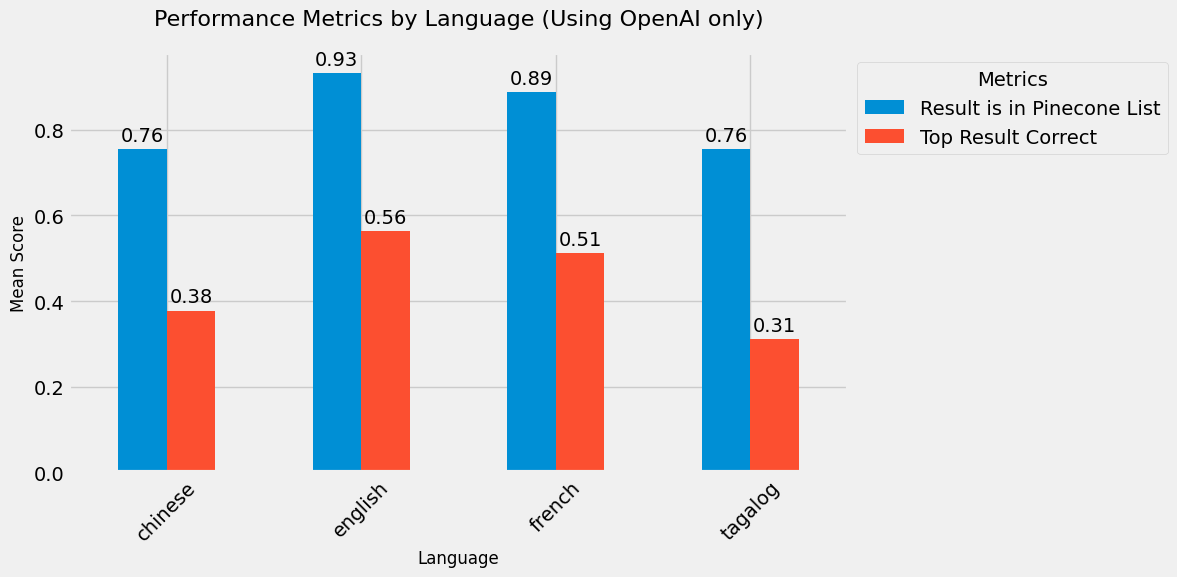

In [59]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results)

print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

import matplotlib.pyplot as plt

# Assuming you've already created results_df
grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')
# sns.set_palette("deep")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (Using OpenAI only)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result is in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## **Making Retrieval Better with [Pongo](https://www.pongo.ai)**

Pongo requires only a few lines extra of code to improve RAG performance.
Their filter uses a collection of auto-encoding models to improve search accuracy at runtime

In [60]:
# pip install pongo

In [61]:
# pip install --upgrade pongo-python

In [103]:
import pongo

PONGO_KEY = "97ddc7c49c704bb6870608ad550e0a3a"
pongo_client = pongo.PongoClient(PONGO_KEY)

In [68]:
docs_for_pongo[0]['metadata']['text']

"\t\t\t\n\nSECOND DIVISION\n[ A.C. No. 8959, October 07, 2020 ]\nRISIE G. BAYGAR, COMPLAINANT, VS. ATTY. CLARO MANUEL M. RIVERA, RESPONDENT.\r\n\r\nD E C I S I O N\n\nHERNANDO, J.:\nThis administrative case arose from a Petition for Disbarment[1] filed by complainant Risie G. Baygar (Risie) against respondent Atty. Claro Manuel M. Rivera (Atty. Rivera) before the Office of the Bar Confidant of this Court. The case was referred to the Commission on Bar Discipline (CBD) of the Integrated Bar of the Philippines (IBP), and docketed as CBD Case No. 12-3391. The Factual Antecedents  In her Petition, Risie alleges that Atty. Rivera committed acts constitutive of a Violation of the Lawyer's Oath and the Code of Professional Responsibility (CPR).[2] At the time of the commission of the acts complained of, Atty. Rivera was the Municipal Administrator[3] of Binangonan, Rizal. In her Complaint, Risie alleged that in the morning of March 9, 2010, officers from the Business Permit and Licensing Offi

In [70]:
convert_to_hash(extract_text_data(docs_for_pongo[0]['metadata']['url']))

'e18a4107c02fb238f3bba557af7d9d9f'

In [75]:
matching_documents_query1[0]['id']

'6a83fe7b3dcf2f105f260b1f94cf0c85'

In [90]:
# docs = [dict(text=result['metadata']['text'], metadata=dict(url=result['metadata']['url'])) for result in docs_for_pongo]
# docs_for_reranking = [dict(text=extract_text_data(result['metadata']['url']), metadata=dict(tags=result['metadata']['tags']), url=result['metadata']['url'])) for result in docs_for_pongo]

docs_for_reranking = [
    {
        "text": summarize_text(extract_text_data(result['metadata']['url'])),
        "metadata": {
            "tags": result['metadata']['tags'],  # Include tags in metadata
            "url": result['metadata']['url']  # Include the URL inside metadata
        }
    }
    for result in matching_documents_query1
]
print('Correct hash ID:', matching_documents_query1[0]['id'])
print('Top Pinecone Search hash ID:', matching_documents_query1[0]['id'])

filtered_result = pongo_client.filter(docs=docs_for_reranking, query=query1, num_results=10)
filtered_docs = filtered_result.json()
top_doc = filtered_docs[0]
top_doc

# print(f"URL: {top_doc['metadata']['url']}\nText: {top_doc['text'][:100]}\nTags: {top_doc['metadata'].get('tags', [])}\nTop Reranked Hash ID: {convert_to_hash(top_doc['text'][:1000])}")
# print(f"""URL: {top_doc['metadata']['url']}
#         \nText: {top_doc['text'][:1000]}
#         \nTags: {top_doc['metadata'].get('tags', [])}
#         \nTop Reranked Hash ID: {convert_to_hash(extract_text_data(top_doc['metadata']['url')))}
# """)
print(f"URL: {top_doc['metadata']['url']}\n"
      f"Text: {top_doc['text'][:50]}\n"
      f"Tags: {top_doc['metadata'].get('tags', [])}\n"
      f"Top Reranked Hash ID: {convert_to_hash(extract_text_data(top_doc['metadata']['url']))}")


Correct hash ID: 6a83fe7b3dcf2f105f260b1f94cf0c85
Top Pinecone Search hash ID: 6a83fe7b3dcf2f105f260b1f94cf0c85
URL: https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/53330
Text: EN BANC
[ G.R. No. 100152, March 31, 2000 ]
ACEBED
Tags: ['respondent City Mayor', 'CITY MAYOR', 'CITY LEGAL OFFICER', 'respondent City', 'CITY']
Top Reranked Hash ID: 6a83fe7b3dcf2f105f260b1f94cf0c85


In [96]:
def test_query_with_pongo(summary, expected_hash, language, top_k=10):
    results = query_from_pinecone(summary, top_k=top_k)
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)
    reranking_docs = [
        {
            "text": summarize_text(extract_text_data(result['metadata']['url'])),
            "metadata": {
                "tags": result['metadata']['tags'],  # Include tags in metadata
                "url": result['metadata']['url']  # Include the URL inside metadata
            }
        }
        for result in results
    ]
    
    filtered_result = pongo_client.filter(docs=reranking_docs, query=summary, num_results=1)
    filtered_docs = filtered_result.json()
    top_doc = filtered_docs[0]
    top_hash = convert_to_hash(extract_text_data(top_doc['metadata']['url']))
    top_result_correct = top_hash == expected_hash

    return dict(
        result_in_pinecone_list=result_in_pinecone_list,
        top_result_correct=top_result_correct,
        language=language,
        expected_hash=expected_hash,
        top_hash=top_hash
    )

In [92]:
synthetic_case_summaries[0]

{'language': 'english',
 'summary': "In a landmark case, a foreign national enrolled in a prestigious university in Metro Manila, Philippines, faced accusations of plagiarism after her dissertation was found to contain numerous uncredited passages from multiple sources. Despite initially passing her oral defense, the university's academic board later recommended the withdrawal of her degree due to the serious nature of the allegations. The student claimed she was denied due process, as the university did not allow her to fully address the charges against her before conferring the degree. After legal challenges, a higher court ruled in her favor, stating the university must restore her degree and ensure the student receives fair treatment in academic matters. This case raised significant questions regarding academic integrity, plagiarism, and students' rights in the educational system.",
 'expected_hash': '49bfbc0ca519af232f9a35286c73ba3d'}

In [97]:
# Test the first item in synthetic data using Pongo reranker
test_query_with_pongo(**synthetic_case_summaries[0])

{'result_in_pinecone_list': True,
 'top_result_correct': False,
 'language': 'english',
 'expected_hash': '49bfbc0ca519af232f9a35286c73ba3d',
 'top_hash': '43daf184b92865d6471619c7d7cdf3ea'}

In [104]:
synthetic_test_results_pongo = []
for synthetic_case_summary in tqdm(synthetic_case_summaries):
    synthetic_test_results_pongo.append(test_query_with_pongo(**synthetic_case_summary))

  8%|▊         | 24/315 [00:55<11:16,  2.32s/it]


ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

result_in_pinecone_list    0.968254
top_result_correct         0.206349
dtype: float64


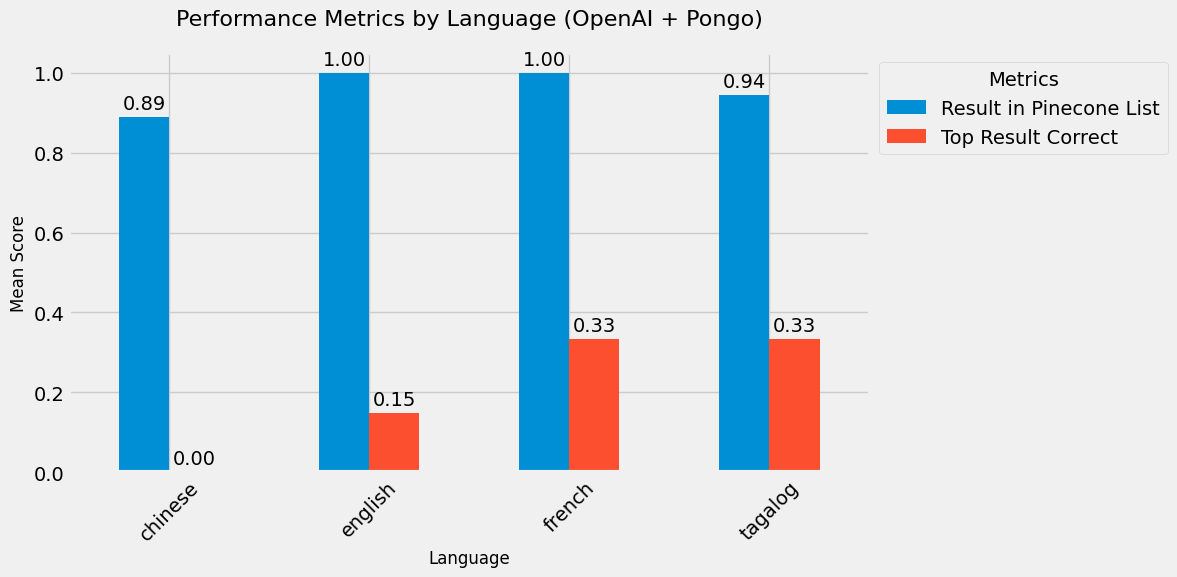

In [100]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results_pongo)
print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI + Pongo)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## **Making Retrieval Better with [Cohere](cohere.com/rerank)**

Similar to Pongo, "Rerank provides a powerful semantic boost to the search quality of any keyword or vector search system without requiring any overhaul or replacement."

In [105]:
# pip install cohere

In [41]:
import cohere

COHERE_API_KEY = config["COHERE_API_KEY"]
co = cohere.Client(COHERE_API_KEY)

In [ ]:
def test_query_with_cohere(summary, expected_hash, language, top_k=10):
        
    results = query_from_pinecone(summary, top_k=top_k)
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)
    # docs = [result['metadata']['text'] for result in results]

    #--------------PROCESS ALL TEXTS HERE--------------s
    
    docs_for_cohere = [result['metadata']['text'] for result in results]

    response = co.rerank(
        model="rerank-multilingual-v3.0",
        query=summary,
        documents=docs,
        top_n=1,
    )

    top_doc = docs[response.results[0].index]
    top_hash = convert_to_hash(extract_text_data(top_doc['metadata']['url']))
    top_result_correct = top_hash == expected_hash

    return dict(
        result_in_pinecone_list=result_in_pinecone_list,
        top_result_correct=top_result_correct,
        language=language,
        expected_hash=expected_hash,
        top_hash=top_hash
    )
    return dict(
        result_in_pinecone_list=result_in_pinecone_list
        top_result_correct=top_result_correct,
        language=language,
        expected_hash=expected_hash,
        top_hash=results[0]['id']
    )

In [ ]:
test_query_with_cohere(**synthetic_questions[0])

In [ ]:
synthetic_test_results_cohere = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results_cohere.append(test_query_with_cohere(**synthetic_question))

In [ ]:
import matplotlib.pyplot as plt

# Data
data = {
    'OpenAI + Cohere': pd.Series([s['top_result_correct'] for s in synthetic_test_results_cohere]).mean() * 100,
    'OpenAI Only': pd.Series([s['top_result_correct'] for s in synthetic_test_results]).mean() * 100
}

percent_change = round((data['OpenAI + Cohere'] - data['OpenAI Only']) / data['OpenAI Only'] * 100, 2)

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))  # Reduced from (10, 6)

# Plot the data
bars = ax.bar(data.keys(), data.values())

# Customize the plot
ax.set_title(
    f'e-Library RAG Results ({percent_change}% {"better" if percent_change > 0 else "worse"} w/ Cohere)', 
    fontsize=16, pad=4)
ax.set_ylabel('Top Result Accuracy (%)', fontsize=12)
ax.tick_params(axis='x')

# Add value labels on top of each bar
ax.bar_label(bars, fmt='%.2f', padding=3)

# Adjust y-axis to start from 0.7 for better visualization of differences
ax.set_ylim(min(data.values()) - 5, max(data.values()) + 2)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## **Text Generation Using OpenAI**

In [108]:
pip install supabase

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


### **Supabase Configuration**

In [57]:
from supabase import create_client, Client
import datetime
from pinecone import Pinecone, ServerlessSpec

from typing import Dict, Optional, Any
import os
from openai import OpenAI
import pandas as pd

from pydantic import BaseModel, Field
from typing import List, Dict, Tuple

In [58]:
SUPABASE_URL: str = config["SUPABASE_URL"]
SUPABASE_API_KEY: str = config["SUPABASE_API_KEY"]

supabase: Client = create_client(SUPABASE_URL, SUPABASE_API_KEY)

### **OpenAIChatLLM Class**

In [59]:
# Define a class for the Chat Language Model
class OpenAIChatLLM(BaseModel):
    model: str = 'gpt-4o'  # Default model to use
    temperature: float = 0.0  # Default temperature for generating responses

    # Method to generate a response from the model based on the provided prompt
    def generate(self, prompt: str, stop: List[str] = None):
        # Create a completion request to the OpenAI API with the given parameters
        response = client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            stop=stop
        )

        # Insert the details of the prompt and response into the 'cost_projecting' table in Supabase
        supabase.table('cost_projecting').insert({
            'prompt': prompt,
            'response': response.choices[0].message.content,
            'input_tokens': response.usage.prompt_tokens,
            'output_tokens': response.usage.completion_tokens,
            'model': self.model,
            'inference_params': {
                'temperature': self.temperature,
                'stop': stop
            },
            'is_openai': True,
            'app': 'RAG'
        }).execute()

        # Return the generated response content
        return response.choices[0].message.content

In [60]:
# Trial OpenAI Chat using Class
c = OpenAIChatLLM()
c.generate('hi')

'Hello! How can I assist you today?'

### **Prompt Engineering for Generated Response**

In [128]:
FINAL_ANSWER_TOKEN = "Legal Assistant Response:"
STOP = '[END]'
PROMPT_TEMPLATE = """Today is {today} and you can retrieve information from a database. Respond to the user's input as best as you can.

Here is an example of the conversation format:

[START]
User Input: the input question you must answer
Context: retrieved context from the database
Context URL: context url
Context Score : a score from 0 - 1 of how strong the information is a match
Assistant Thought: This context has sufficient information to answer the question.
Assistant Response: your final answer to the original input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: more retrieved context from the database
Context URL: context url
Context Score : another score from 0 - 1 of how strong the information is a match
Assistant Thought: This context does not have sufficient information to answer the question.
Assistant Response: your final answer to the second input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: NO CONTEXT FOUND
Context URL: NONE
Context Score : 0
Assistant Thought: We either could not find something or we don't need to look something up
Assistant Response: Reason through the best way to answer
[END]

Begin:

{running_convo}
"""

In [146]:
class RagBot(BaseModel):
    llm: Any
    prompt_template: str = PROMPT_TEMPLATE
    stop_pattern: List[str] = [STOP]
    user_inputs: List[str] = []
    ai_responses: List[str] = []
    contexts: List[Tuple[str, float]] = []
    verbose: bool = False
    threshold: float = 0.40

    def query_from_pinecone(self, query, top_k=1, include_metadata=True):
        return query_from_pinecone(query, top_k, include_metadata)

    @property
    def running_convo(self):
        convo = ''
        for index in range(len(self.user_inputs)):
            convo += f'[START]\nUser Input: {self.user_inputs[index]}\n'
            convo += f'Context: {self.contexts[index][0]}\nContext URL: {self.contexts[index][1]}\nContext Score: {self.contexts[index][2]}\n'
            if len(self.ai_responses) > index:
                convo += self.ai_responses[index]
                convo += '\n[END]\n'
        return convo.strip()

    def expand_query(self, query):
        # Expand short queries to provide more context
        if len(query.split()) < 5:  # Adjust threshold as needed
            return f"Provide a detailed explanation of: {query}. Include its legal provisions, history, and key implications."
        return query
        
    def run(self, question: str):
        expanded_question = self.expand_query(question)
        self.user_inputs.append(expanded_question)
        top_response = self.query_from_pinecone(expanded_question)[0]
        print(top_response['score'])
        if top_response['score'] >= self.threshold:
            self.contexts.append((extract_text_data(top_response['metadata']['url']), top_response['metadata']['url'], top_response['score']))
        else:
            self.contexts.append(('NO CONTEXT FOUND', 'NONE', 0))

        prompt = self.prompt_template.format(
                today=datetime.now(),
                running_convo=self.running_convo
        )
        if self.verbose:
            print('--------')
            print('PROMPT')
            print('--------')
            print(prompt)
            print('--------')
            print('END PROMPT')
            print('--------')
        generated = self.llm.generate(prompt, stop=self.stop_pattern)
        if self.verbose:
            print('--------')
            print('GENERATED')
            print('--------')
            print(generated)
            print('--------')
            print('END GENERATED')
            print('--------')
        self.ai_responses.append(generated)
        if FINAL_ANSWER_TOKEN in generated:
            generated = generated.split(FINAL_ANSWER_TOKEN)[-1]
        return generated

In [ ]:
            # self.contexts.append(("""FIRST DIVISION\n[ G.R. No. 241360•, July 06, 2021 ]\nMICHELLE* TAY, PETITIONER, VS. APEX 8 STUDIOS, INC. AND CRISTINA** MARTINEZ, RESPONDENTS.\r\n\r\nD E C I S I O N\n\nCAGUIOA, J:\nThis is a Petition for Review on Certiorari[1] (Petition) under Rule 45 of the Rules of Court filed by Michelle Tay (petitioner) assailing the Court of Appeals (CA) Decision[2] dated February 6, 2018 and Resolution[3] dated June 26, 2018 in CA-G.R. SP No. 141218.  The Antecedent Facts  Petitioner was hired by Apex 8 Studios, Inc. (Apex), represented herein by its human resource (HR) manager, Cristina Martinez (Martinez), (collectively respondents), as administrative manager on September 20, 2013.  Several notices to explain (NTE) for violation of company policy were issued to petitioner. A summary of the NTEs and petitioner's Replies thereto are narrated below:  1. Memorandum[4] dated May 15, 2014 re: \"Offenses against person \"based on a complaint from Nino Lanohan[5] (Lanohan) for unannounced employee evaluation, utterance of foul words, and throwing of ballpen and paper at the person evaluated on May 13, 2014 (First NTE).[6]  In her Reply[7] to the First NTE, petitioner asserted that Lanohan was aware of the evaluation and the same was documented, submitting the post evaluation report[8] signed by Lanohan dated May 13, 2014 and previous evaluations of Lanohan.[9] She denied the allegations of an altercation and claimed that these were false accusations of Lanohan who had become emotional after his evaluation.[10]  2. Memorandum[11] dated May 15, 2014 re: \"Offenses against Company Code of Conduct\" based on a complaint from Benjalyn[12] Nicanor (Nicanor) who alleged that petitioner committed unpleasant, unprofessional, and inappropriate behavior in the workplace and acted in an aggressive tone as if provoking a fight (Second NTE).[13] Nicanor alleged that he received reports of an earlier commotion between petitioner and Lanohan in the common area of the office. Nicanor also alleged that petitioner aggressively confronted Nicanor and other employees in the office pantry when she overheard them talking about the earlier commotion between petitioner and Lanohan.[14] In her Reply[15] dated May 19, 2014, petitioner denied that she acted in an aggressive, inappropriate, unpleasant, or unprofessional manner toward Nicanor and other employees in the pantry. With regard to the previous incident between petitioner and Lanohan, petitioner claimed that what happened was a typical office interaction between her and Lanohan as she tried to address his inadequacies at work. She calmly reacted and tried to give instructions for the proper execution of his job.[16] 3. Memorandum[17] dated May 15, 2014 re: \"Offenses against attendance and punctuality\" for failure to notify of inability to report and absence without leave or call (Third NTE).[18] Petitioner submitted a Reply[19] asserting that she was sick on May 7, 2014 and attached thereto an email[20] dated May 7, 2014 where she explained that she was not feeling well and apologized for the late notice. 4. Memorandum[21] dated May 15, 2014 re: \"Offenses against person\" for asking the Chief Operating Officer Thorsten Hillebrecht (COO Hillebrecht) to talk to a food delivery personnel in a high voice without introducing COO Hillebrecht and asking for an unannounced meeting on May 14, 2014 (Fourth NTE).[22] Petitioner submitted a Reply[23] dated May 19, 2014 alleging that she did not act in a disrespectful manner as she introduced COO Hillebrecht to the food delivery personnel inside the boardroom which is the proper venue for the introduction. As to the meeting, she merely requested the same to discuss a violation committed by an employee but the request was denied.[24] 5. Memorandum[25] dated May 16, 2014 re: \"Work Responsibility\" for failure to stock snacks and food supplies (Fifth NTE) on May 16, 2014.[26]  Petitioner submitted a Reply[27] dated May 20, 2014 asserting that the issue had been addressed after she had received a report of \"missing 'popcorn'\" requested by the Chief Executive Office (CEO).[28] She was requested to send one box of popcorn from the Apex's Zuellig office to the PBCom office which she complied with. She also requested for a budget to replenish the supplies and immediately procured snacks upon release of the check.[29]  6. Memorandum[30] dated May 21, 2014 re: \"Insubordination and work responsibility\" for failing to comply with duties and responsibilities, abrasive attitude towards staff, tardiness, delayed submission of management reports, and inefficiency (Sixth NTE).[31] In the Sixth NTE, petitioner was also informed that she would be placed under preventive suspension for a period of 30 days without pay or until June 20, 2014.[32]  Petitioner answered the Sixth NTE in a Reply[33] dated May 28, 2014 denying that she had acted in an abrasive manner, and asserting that she had maintained camaraderie and cooperation with her co-workers.[34] Petitioner denied the allegation that she was failing in the performance of her tasks. She answered that she had emailed the status updates of her weekly tasks to the COO and attached an email thereof.[35] She admitted that she had submitted a Report requested from all department heads regarding development of fiscal goals and objectives, plans and strategies, and averred that she had advised the financial manager ahead of time that there would be delay as she was on bereavement leave at the time.[36]  7. Memorandum[37] dated June 10, 2014 re: \"Offenses against company property/property of others/offenses against company interest, dishonesty, and disloyalty\" for allegedly allowing makeup artist Raven[38] Agarpao (Agarpao) to take an eyeshadow makeup palette without company consent (Seventh NTE).[39] Petitioner denied the accusation that she allowed Agarpao to take an eye shadow makeup palette. In the first place, petitioner asserted that the handling of the makeup supplies was the task of Nicanor. She also attached a letter[40] from Agarpao who denied taking home any makeup product.[41]  8. Memorandum[42] dated June 10, 2014 re: \"Offenses against company interest, dishonesty, and disloyalty\" for consenting to give food to the guard on duty as a bribe in order to waive the gate pass requirement for the company's food concessionaire (Eighth NTE).[43]  Petitioner denied consenting to giving food to the guard on duty and submitted a statement from the food concessionaire alleging that it was Lanohan who gave food to the guards and that petitioner had no participation in or knowledge of said act.[44] An administrative hearing was conducted on June 10, 2014 and petitioner submitted a Supplemental Explanation[45] thereafter. On June 20, 2014 respondents extended petitioner's suspension but with pay.[46] On June 23, 2014, respondents served a Notice of Termination[47] to petitioner, finding her guilty of the infractions contained in the the First, Second, Fourth, Fifth, Sixth, Seventh, and Eighth NTEs on the grounds of violation of code of conduct, serious misconduct, fraud or willful breach of trust, gross and habitual neglect of duties, and loss of trust and confidence. Thus, petitioner filed a complaint[48] before the Labor Arbiter (LA) for illegal suspension, illegal dismissal, payment of backwages, separation pay, moral and exemplary damages, attorney's fees, and costs of suit.  In her Position Paper,[49] petitioner alleged that her dismissal was a retaliatory act of Apex's Global Director for Talent Resources, Jonathan Sullivan (Sullivan) after the latter read a Facebook post on May 15, 2014 made by petitioner's husband which indicated the qualities of a good leader.[50] Petitioner averred that Sullivan interpreted the Facebook post as a criticism of his management style and he sent text messages to petitioner asking about the post.[51] Sullivan, in connivance with HR Manager Martinez, used the Facebook post as a ground to dismiss petitioner from employment.[52] On the other hand, respondents maintained that petitioner was validly dismissed for just cause and with observance of procedural due process.[53] The LA Decision  The LA held that petitioner, a managerial employee, was validly suspended and dismissed on the ground of loss of trust and confidence due to her actions and aggressive behavior. The LA found that petitioner's conflicts with her co-workers showed that she was \"totally incapable of peaceful co-existence\"[54] in the workplace.[55]  The LA also held that petitioner was unable to prove that her dismissal was motivated by revenge due merely to her husband's Facebook post. Moreover, there was no showing that her co-workers Lanohan and Nicanor were merely coerced or motivated by malice in reporting her infractions. The LA also held that procedural due process was observed in the implementation of the dismissal.[56] The LA did not discuss the other grounds cited in the Notice of Termination. Thus, petitioner appealed the case to the National Labor Relations Commission (NLRC). The NLRC Decision  The NLRC reversed the LA Decision[57] and held that petitioner's suspension and subsequent dismissal were illegal. With regard to the suspension, the NLRC held that it was baseless because respondents were unable to prove that petitioner's presence in the workplace posed an imminent or serious threat to the life and/or property of respondents and its employees.[58] On the issue of illegal dismissal, the NLRC held that the charges against petitioner were not proven with substantial evidence, thus, there was no just cause for her dismissal. The complaints against petitioner were based on unverified emails and unsigned letters from employees as respondents did not submit the affidavits of the said employees.[59] The NLRC, however, agreed with the LA that respondents complied with procedural due process in terminating petitioner's employment.[60] The dispositive portion of the NLRC Decision[61] reads:   WHEREFORE, premises considered, the appeal of [petitioner] is hereby granted. The Decision of the Labor Arbiter dated 08 October 2014 is REVERSED and SET ASIDE. [Petitioner] is declared to have been illegally dismissed and [respondents] are hereby ordered to pay jointly and severally [petitioner] her wages during the time of illegal preventive suspension from 21 May 2014 to 22 June 2014; full backwages from 23 June 2014 until the finality of this Decision; separation pay in lieu of reinstatement equivalent to one month pay for every year of service with a fraction of at least six (6) months to be considered as one whole year to be computed from date of employment on 20 September 2013 until the finality of this Decision; moral damages in the amount of P25,000.00; exemplary damages of P25,000.00; and ten percent (10%) attorney's fees on the monetary award.[62] (Emphasis in the original)   Respondents filed a Motion for Reconsideration[63] (MR) attaching thereto, the affidavits of employees Lanohan, Nicanor, and COO Hillebrecht.[64] However, the NLRC denied the MR in its Resolution[65] dated April 30, 2015, and did not give credence to the affidavits as they were belatedly filed. The NLRC held that while technical rules of procedure are not binding in administrative cases, the delayed submission of relevant documents must be justified. Respondents did not present a justifiable reason for the late submission of the affidavits of their witnesses. The failure to produce the said documents was clearly their own fault as the witnesses were at their disposal from the beginning. They would not suffer any deprivation of due process as they had ample opportunity to submit the affidavits with their Position Paper before the LA and their Memorandum of Appeal before the NLRC, but they neglected to do so.[66] The CA Decision  The CA reversed the NLRC Decision and agreed with the LA Decision that there was just cause for petitioner's dismissal. Contrary to the NLRC's findings, the CA held that there was substantial evidence to prove that petitioner committed serious misconduct, gross neglect of duties, and breach of trust and confidence. The CA found that petitioner's utterance of foul words, throwing of pen and paper, aggressive behavior aimed at provoking a fight, and disrespectful behavior towards fellow employees Lanohan and Nicanor and the company COO Hillebrecht constituted serious misconduct. The CA held that petitioner only proffered denials and alibis which impliedly admitted that the incidents indeed transpired. The CA further ruled that petitioner's actions resulted in the loss of trust and confidence in her as a managerial employee. The CA also held that the NLRC is not bound by technical rules of evidence even during the appeal and filing of MR. Thus, the NLRC should have allowed the belated filing of the affidavits as part of respondents' evidence.[67] Petitioner filed an MR,[68] which was denied by the CA in its Resolution dated June 26, 2018. Thus, petitioner filed the instant Petition imputing reversible error on the CA in reversing the NLRC Decision and holding that her suspension and dismissal were valid.  Respondents filed their Comment,[69] asserting that the CA correctly ruled in reversing the NLRC Decision. They argue that petitioner merely rehashed the arguments she raised before the CA which have been already properly addressed. Respondents also contend that the Petition is defective as the Verification and Certification of Non-Forum Shopping[70] (Verification and Certification) was signed by petitioner's husband Eugenio Tay (Eugenio) who presented no proof that he was authorized to sign on behalf of petitioner. Petitioner filed a Reply[71] asserting that a Special Power of Attorney[72] (SPA) dated May 8, 2015 is attached to the Verification and Certification, paragraph 6 of which expressly authorizes Eugenio to file the instant Petition before the Court. Issue  Whether the CA committed reversible error in reversing the NLRC Decision and Resolution. The Court's Ruling  The petition is meritorious. In determining the issue of whether petitioner was validly dismissed on the grounds of serious misconduct, fraud or willful breach of trust, gross and habitual neglect of duties, and loss of trust and confidence, the Court was compelled to re-examine the factual issues in the case. Generally, petitions for review on certiorari under Rule 45 are limited to questions of law as factual findings of administrative agencies are accorded great weight and respect due to their specific expertise and jurisdiction. In exceptional cases, however, a review of the records may be warranted when the factual findings of the LA, NLRC, and CA are contradictory, as in this case.[73]  In labor disputes, the employer has the burden to prove that the disciplinary action imposed on the employee was done with just cause. The quantum of proof required is substantial evidence, which is defined as \"such relevant evidence as a reasonable mind might accept as adequate to support a conclusion.\"[74] Upon a judicious review of the case, the Court finds that the CA committed reversible error in overturning the NLRC Decision. The NLRC did not commit grave abuse of discretion amounting to lack or excess of jurisdiction in holding that there was no valid ground for the preventive suspension, and no just cause for the dismissal of petitioner.  Before proceeding to discuss the substantive issues in the case, the Court first determines the issue of the validity of the Verification and Certification. The SPA executed by petitioner clearly and categorically authorizes Eugenio to represent her in this labor dispute and to perform acts in pursuance of the case, including the signing of pleadings and verification and certification of non-forum shopping of such pleadings and the filing of the Petition before the Court.[75] Thus, contrary to respondents' contention, the Verification and Certification is valid as Eugenio is clothed with authority to sign the Verification and Certification.   There was no valid ground for the preventive suspension    Under Sections 8 and 9, Rule XXIII, Book V of the Omnibus Rules to Implement the Labor Code, as amended,[76] the employer may place the employee under preventive suspension for a maximum period of 30 days if his or her continued presence in the workplace poses a serious and imminent threat to the life or property of his or her co-workers.  Preventive suspension is a disciplinary measure for the protection of the company and its employees pending investigation of the alleged wrongdoing committed by the employee. However, when it is found that the preventive suspension was without sufficient basis, the employee is entitled to the payment of salaries during the preventive suspension.[77] In cases involving dishonesty, the Court has held that preventive suspension is an acceptable precautionary measure in order to preserve the integrity of vital papers and documents that may be material and relevant to the case and which the employee may have access to by virtue of his or her position.[78] As correctly noted by the NLRC, the preventive suspension was imposed on petitioner on May 21, 2014 before the issuance of the Memorandum dated June 10, 2014 which contained the charge of alleged consent to theft and bribery. Thus, there was no charge of dishonesty or fraud yet when the preventive suspension was imposed. The grounds relied upon by respondents in imposing the preventive suspension referred to the infractions detailed in the First to Fifth NTEs which involved the charges of (1) rude behavior towards Lanohan; (2) unpleasant, unprofessional, and inappropriate behavior towards Nicanor; (3) absence without official leave; (4) rude behavior towards COO Hillebrecht; and (5) no stock of food and snacks.  The Court is not convinced that the above incidents are justifiable basis for preventive suspension. Respondents failed to present any substantial evidence of how petitioner's presence in the work place posed a serious and imminent threat to the life and property of the company and its employees to justify petitioner's suspension for 30 days. Respondents likewise did not prove that petitioner's presence would hinder or obstruct the investigation. Thus, the preventive suspension imposed on petitioner was illegal and she is entitled to her unpaid salaries for the period that she was preventively suspended without pay.   There was no just cause for illegal dismissal    The charge in the First, Second and Fourth NTEs which were upheld in the Notice of Termination, will be discussed together as they refer to similar allegations regarding petitioner's behavior and interactions with her co-workers.  The NLRC did not give credence to the allegations in the NTEs because they were not supported by affidavits of the complainants Lanohan, Nicanor, and COO Hillebrecht. The affidavits were submitted belatedly as attachments to respondents' MR before the NLRC. On the other hand, the CA took a liberal approach and appreciated the belatedly submitted affidavits reasoning that the NLRC is not bound by technical rules of evidence.  The Court does not agree with the CA. The NLRC cannot be faulted for disregarding the belatedly submitted affidavits in the absence of any adequate reason for their late submission. While it is true that strict adherence to technical rules of procedure is not required in labor cases, liberality may be allowed only when the errant party is able to adequately explain the delay in the submission of evidence and sufficiently prove the allegations sought to be proven.[79] Section 11, Rule V of the NLRC Rules of Procedure requires the parties to submit their verified position papers with supporting documents and affidavits of witnesses, which shall take the place of their direct testimony.[80] It is clear that the affidavits should be submitted with the position paper, at the initial stage of the case. In this case, respondents' witnesses were its own employees and COO. Thus, they could have easily submitted their affidavits with their Position Paper filed before the LA. Respondents, however, failed to provide any justifiable reason for the delay of the submission of said documents. As the employer, it was incumbent upon respondents to prove their allegations with substantial evidence.  In any case, even if the Court were to consider the unverified statements against petitioner, the allegations contained in the First, Second, and Fourth NTEs do not constitute serious misconduct to justify the harsh penalty of dismissal. In Maula v. Ximex Delivery Express, Inc.,[81] the Court explained the definition and elements of serious misconduct. The Court held:   Misconduct is improper or wrong conduct; it is the transgression of some established and definite rule of action, a forbidden act, a dereliction of duty, willful in character, and implies wrongful intent and not mere error in judgment. The misconduct, to be serious within the meaning of the Labor Code, must be of such a grave and aggravated character and not merely trivial or unimportant. Thus, for misconduct or improper behavior to be a just cause for dismissal, (a) it must be serious; (b) it must relate to the performance of the employee's duties; and (c) it must show that the employee has become unfit to continue working for the employer.[82](Emphasis supplied)   The First NTE[83] contained Lanohan's report that petitioner conducted an unannounced evaluation without proper documentation, uttered foul words, and threw a pen and paper on May 13, 2014. While the Court has previously ruled that the utterance of obscene, insulting, and offensive words and fighting in company premises[84] may be valid grounds for termination, the allegations in the NTEs are too broad and general to be interpreted as serious misconduct. The First NTE alleged that petitioner uttered foul words but it does not state the words that were actually uttered. The description of the utterances as \"foul word\"[85] is a conclusion and not a mere factual narration. The interpretation of words is highly subjective and the Court cannot just accept one party's description of utterances without a specification of the actual words uttered. It was also alleged that petitioner conducted an unannounced evaluation but respondents were unable to prove how the said act was a violation of the company's code of conduct or procedures in evaluation of employees. The allegation that petitioner threw a pen and paper at Lanohan deserves scant consideration as this was unverified and unsubstantiated. The Second NTE[86] alleged that petitioner acted in an unpleasant, unprofessional and inappropriate manner toward Nicanor, based on an unsigned letter which stated:   \"This morning, I [Nicanor] got a report from my Pitboss Rio and Make-up artist Elaine that there was a commotion between [petitioner] (Admin Manager) and [Lanohan] (cleaner supervisor) during clean ups that leads to walking out of the latter from the room.  Such acts should not be done in a common area as this may create emotional distress to the staff that may disrupt organizational functions. This kind of behavior is unpleasant, unprofessional, and inappropriate in a workplace wherein we are promoting harmonious relationships between staff in the operations department.  In lieu with (sic) the above mentioned report, [petitioner] popped in the pantry area at around 10[:]30am coming from outside saying \"are you talking behind my back\" and \"I heard my name being mentioned here as I walked in\" pertaining to Me [Nicanor] (Operations Manager), Tina (HR Manager), [Lanohan] (cleaner supervisor)[,] Laila (project coordinator) and Venus (cleaner). Her tone was very aggressive as if she is provoking into a fight.   Silence comes after the resounding voice and staffs (sic) were frightened because of this.\"[87] (Italics in the original)    The allegations in the Second NTE, even if taken to be true, likewise do not constitute serious misconduct. The utterances \"are you talking behind my back?\" and \"I heard my name being mentioned here as I walked in\"[88] cannot, by themselves, be interpreted as aggressive and provocative. The statements were merely questions propounded to the persons present in the pantry. As stated in the NTE, there was silence after, which signifies that there was no altercation or commotion that ensued after the utterances. As to the allegation of the separate commotion between petitioner and Lanohan, the same deserves no consideration as it was merely relayed to Nicanor by other employees. Significantly, Lanohan himself did not report the incident.  With regard to the charges in the Fourth NTE,[89] the Court does not find that petitioner's failure to introduce the COO Hillebrecht to the food delivery personnel and requesting for an unannounced meeting, constitute serious misconduct. The said imputed acts do not constitute misconduct so grave to justify dismissal. Respondents failed to prove that the purported acts were violations of the company code of conduct. Respondents alleged in the Notice of Termination that other employees attested that petitioner did not introduce COO Hillebrecht to the delivery personnel and acted in a condescending manner,[90] yet they did not submit affidavits of the other employees who witnessed the incident. Moreover, asking for a meeting, whether announced or unannounced, does not constitute misconduct.  Respondents were unable to substantiate that the above acts constituted just causes for dismissal. They failed to prove that petitioner committed serious misconduct relating to her duties which demonstrated unfitness to continue working for the company. Respondents attempted to depict petitioner as an employee who did not get along well with her colleagues, akin to an allegation of having an \"attitude problem.\" While the Court has previously held that an employee's attitude problem may be a valid ground for termination as it is detrimental to the company, cause strain at the working environment, and affect teamwork,[91] respondents were unable to prove with substantial evidence that this was the situation in this case. Such an allegation must be proven with substantial evidence detailing the specific acts of the employee which demonstrate negative behavior to such a degree that it negatively affects the other employees, the work environment, and impacts on the employee's work. In Sy v. Neat, Inc,[92] where one of the grounds for dismissal was also the employee's alleged attitude problem, the Court held:   With respect to Sy's attitude problem, the Court finds no evidence to substantiate such allegation. Aside from the allegations in the August 5, 2012 memorandum to the effect that the Operations Managers have complained about his attitude problem, nothing in the records show that Sy was previously warned for not following instructions, and for arguing with or disrespecting his superiors. Bare allegations, unsubstantiated by evidence, are not equivalent to proof under our Rules. To be sure, unsubstantiated suspicions, accusations and conclusions of employers do not provide for legal justification for dismissing an employee. Respondents failed to present reports or sworn statements of the Operations Managers, narrating the instances when he displayed attitude problems at work, as well as his previous Performance Appraisal indicating unsatisfactory evaluation of his work.[93] (Emphasis supplied)   The CA also committed reversible error in holding that petitioner's denial of the charges regarding her attitude constituted an implied admission. The evidence must be weighed based on the strength of the employers' evidence as the burden is on them to prove that the dismissal as valid.  In Heavylift Manila, Inc. v. Court of Appeals,[94] the Court held   However, we are not convinced that in the present case, petitioners have shown sufficiently clear and convincing evidence to justify Galay's termination. Though they are correct in saying that in this case, proof beyond reasonable doubt is not required, still there must be substantial evidence to support the termination on the ground of attitude. The mere mention of negative feedback from her team members, and the letter dated February 23, 1999, are not proof of her attitude problem. Likewise, her failure to refute petitioners' allegations of her negative attitude does not amount to admission. Technical rules of procedure are not binding in labor cases. Besides, the burden of proof is not on the employee but on the employer who must affirmatively show adequate evidence that the dismissal was for justifiable cause.[95] (Emphasis supplied)    The charge in the Third NTE[96] relating to petitioner's attendance, was not included in the Notice of Termination as a ground for dismissal. Accordingly, it will no longer be discussed.  The Notice of Termination also found petitioner guilty of the charges in the Fifth and Sixth NTEs for gross inefficiency in her work performance. Under Section 297 of the Labor Code, gross and habitual neglect of duties is a just cause for dismissal. In Cavite Apparel, Incorporated v. Marquez[97] the Court held:   Neglect of duty, to be a ground for dismissal under Article 282 of the Labor Code, must be both gross and habitual. Gross negligence implies want of care in the performance of one's duties. Habitual neglect imparts repeated failure to perform one's duties for a period of time, depending on the circumstances. x x x.[98]    The charges in the Fifth NTE[99] pertain to petitioner's alleged failure to monitor the supply of snacks in Apex's PBCom office despite repeated reminders. Petitioner admitted that there were no snacks in the PBCom office on May 16, 2014 but proffered that she was able to send snacks from the Zuellig Office to the PBCom office and to purchase more snacks on the same day.  Under the standards in Cavite Apparel, the Court finds that petitioner did not commit gross and habitual neglect of duty. The lack of snacks was reported only on May 16, 2014. Respondents alleged that repeated reminders were given to petitioner regarding the snacks, yet they failed to submit any proof that petitioner had been previously reminded or reprimanded for the same act. Moreover, as explained by petitioner, the situation was immediately remedied as she was able to replenish the supply of snacks. As correctly held by the NLRC, the failure to monitor the snacks in the PBCom office was not so crucial for the business operation of Apex to make it a terminable offense. Thus, the said act does not constitute gross negligence.  The Sixth NTE[100] accused petitioner of failing to comply with duties and responsibilities, abrasive attitude towards staff, tardiness, delayed submission of management reports, and inefficiency. However, respondents did not specify the acts of petitioner constituting said infractions and they failed to submit any substantial evidence to prove these allegations. The general allegations in the Sixth NTE were also not individually addressed in the Notice of Termination. Mere general recitations of an employee's infractions are not sufficient to convince the Court. The employer must allege and prove the specific acts of the employee which violated the company's code of conduct. Mere allegation is not evidence.[101] As the employer, respondents failed to discharge the burden of presenting substantial evidence to prove the allegations in the Sixth NTE.  Respondents also found petitioner guilty of committing fraud and willful breach of trust, based on the allegations in the Seventh and Eighth NTEs. In the Seventh NTE,[102] it was alleged that petitioner allowed a makeup artist, Agarpao, to take an eyeshadow makeup palette without company consent. The charge was based on an email[103] from Therese Angela Jose (Jose) who alleged that she last saw the missing eyeshadow palette in the possession of Agarpao, who declared that she had asked permission from petitioner to take the item since it had been already used up. Agarpao allegedly told Jose that she offered to pay for the item but petitioner refused and just gave her the eyeshadow palette. Respondents also submitted a handwritten letter[104] from another makeup artist, Elaine Robles (Robles) who alleged that she overheard Agarpao telling another make-up artist that petitioner gave Agarpao the make-up palette since it was already used up.  The allegations contained in the email and letter deserve scant consideration as respondents did not submit the affidavits of Jose and Robles to confirm their statements. In any case, even if the Court were to accept the unverified statements, still there would be no substantial evidence against petitioner because the statements are mere hearsay. Jose did not see the actual taking of the item or petitioner's alleged consent to the taking thereof, she only averred that Agarpao told her that petitioner allowed her to take the item. Meanwhile, Robles merely averred that she overheard Agarpao say that petitioner gave her the make-up palette. Both had no personal knowledge of the allegation that petitioner gave her consent to the taking of the item. Respondents did not conduct any investigation on the alleged incident and merely relied on the hearsay statements of Jose and Robles. The NTE did not even indicate the date of the alleged theft. The Eighth NTE[105] charged petitioner with consenting to the act of Lanohan in giving of food as a bribe to the security guards in PBCom to allow Apex's food concessionaire to enter the building without a gate pass. This is another baseless and unsubstantiated charge against petitioner. The NTE alleged that the report was \"[b]ased on the information turned over to us,\"[106] and yet, no affidavit or report was submitted to support the charge. In the Notice of Termination, respondents declared that the company had directed Lanohan to explain his side, but did not elucidate on Lanohan's explanation. It is therefore apparent that respondents did not have any substantial evidence to prove that petitioner had consented to the giving of food to the guards. The Court notes that respondents were unable to directly impute any act of fraud or willful breach of trust against petitioner and merely tried to implicate her in alleged infractions of other employees.  Lastly, respondents also used loss of trust and confidence as basis for termination of employment in the Notice of Termination. The Court finds that there is no substantial evidence to prove that petitioner committed acts which could have resulted in loss of trust and confidence in petitioner as a managerial employee. The Court has previously ruled that loss of trust and confidence may be a basis for the dismissal of managerial employees owing to the confidential and fiduciary nature of their position. However, the loss of trust and confidence must have real basis and not be based on mere suspicions or speculations. In Lima Lands, Inc. v. Cuevas,[107] the Court held:   x x x [T]he loss of trust and confidence must be based not on ordinary breach by the employee of the trust reposed in him by the employer, but, in the language of Article 282 (c) of the Labor Code, on willful breach. A breach is willful if it is done intentionally, knowingly and purposely, without justifiable excuse, as distinguished from an act done carelessly, thoughtlessly, heedlessly or inadvertently. It must rest on substantial grounds and not on the employer's arbitrariness, whims, caprices or suspicion; otherwise, the employee would eternally remain at the mercy of the employer. It should be genuine and not simulated; nor should it appear as a mere afterthought to justify earlier action taken in bad faith or a subterfuge for causes which are improper, illegal or unjustified. There must, therefore, be an actual breach of duty committed by the employee which must be established by substantial evidence. Moreover, the burden of proof required in labor cases must be amply discharged.[108]   In sum, respondents miserably failed to prove that petitioner's suspension and subsequent dismissal were based on any just cause. Respondents failed to discharge the burden of proving with substantial evidence the alleged infractions of petitioner to justify the imposition of preventive suspension and the ultimate penalty of dismissal.   Petitioner is entitled to unpaid wages, backwages, separation pay, moral and exemplary damages, and attorney's fees    The Court reinstates the NLRC's monetary awards.  Petitioner is entitled to her unpaid wages for the period of her illegal preventive suspension from May 21 to June 20, 2014 and for the period of extension on June 21, 2014 until June 22, 2014. An employee is entitled to the payment of salaries during the preventive suspension when it is found that the imposition thereof was without sufficient basis.[109] The Court notes that petitioner's suspension was extended beyond June 20, 2014, but with pay. If her salary for June 21 and 22, 2014 has already been paid, the same shall be excluded in the computation of unpaid salaries for the period of illegal preventive suspension.  The NLRC also correctly ruled that petitioner is entitled to backwages and separation pay, in lieu of reinstatement due to the strained relations between the parties. In Aliling v. Feliciano,[110] the Court distinguished the two awards:   \"The basis for the payment of backwages is different from that for the award of separation pay. Separation pay is granted where reinstatement is no longer advisable because of strained relations between the employee and the employer. Backwages represent compensation that should have been earned but were not collected because of the unjust dismissal. The basis for computing backwages is usually the length of the employee's service while that for separation pay is the actual period when the employee was unlawfully prevented from working.[\"][111]   Undoubtedly, the relationship between petitioner and respondents is strained and reinstatement would not be viable. Thus, the grant of separation pay is justified.  The NLRC's award of moral and exemplary damages is also justified as petitioner's dismissal was attended with bad faith. In Daguinod v. Southgate Foods, Inc.,[112] the Court held:   x x x Moral damages are awarded in illegal termination cases when the employer acted (a) in bad faith or fraud; (b) in a manner oppressive to labor; or (c) in a manner contrary to morals, good customs, or public policy. In addition to moral damages, exemplary damages may be imposed by way of example or correction for the public good. In contracts and quasi-contracts, the court may award exemplary damages if the defendant acted in a wanton, fraudulent, reckless, oppressive, or malevolent manner.[113]    Respondents clearly acted in bad faith in implementing petitioner's dismissal. Respondents bombarded petitioner with eight (8) NTEs which contained baseless allegations and dismissed her without a proper investigation of the complaints against her. They implicated petitioner in fraudulent and dishonest acts without any substantial basis, disparaged her work performance without conducting a proper assessment, and trampled on her character. The NLRC awarded moral and exemplary damages of P25,000.00 each. The Court deems it appropriate to raise the amounts to P50,000.00 each, considering that respondents' treatment of petitioner was blatantly unfair and very oppressive. The Court also affirms the NLRC's award of attorney's fees of ten percent (10%) of the total monetary award. In cases for recovery of wages or when an employee was compelled to file suit to protest his or her rights, the award of attorney’s fees is justifiable.[114] WHEREFORE, premises considered, the Petition is GRANTED. The Court further RESOLVES to:    1. REVERSE and SET ASIDE the CA Decision dated February 6, 2018 and Resolution dated June 26, 2018 in CA-G.R. SP No. 141218.          2. REINSTATE the Decision of the NLRC in NLRC LAC No. 11-002899-14 with modification as to the amount of moral and exemplary damages.         3. Respondents Apex 8 Studios, Inc. and Cristina Martinez are DIRECTED to PAY petitioner Michelle H. Tay the following monetary awards, which shall be their joint and solidary liability:             a) unpaid salaries for the period of preventive suspension without pay from May 21 to June 20, 2014 and for the period of extension on June 21, 2014 until June 22, 2014, if unpaid;            b) full backwages from the date of dismissal on June 23, 2014 until finality of this judgment;             c)  separation pay in lieu of reinstatement computed from the beginning of employment on September 20, 2013 until finality of this judgment;             d) moral damages of P50,000.00;            e) exemplary damages of P50,000.00; and            f)  attorney's fees of 10% of the monetary award.    The total monetary award shall be subject to legal interest at the rate of six percent (6%) per annum from the finality of this Decision until full payment.[115]  SO ORDERED. Gesmundo, C.J., (Chairperson), Carandang, Zalameda, and Gaerlan, JJ., concur.  • Formerly UDK 16271. * \"Mizzie,\" \"Mizzy,\" and \"Missy\" in some parts of the rollo. ** \"Tina\" in some parts of the rollo.[1] Rollo, Vol. I, pp. 2-44.  [2] Rollo, Vol. II, pp. 646-665. Penned by Associate Justice Nina G. Antonio-Valenzuela with the concurrence of Associate Justices Priscilla J. Baltazar-Padilla (a retired Member of the Court) and Germano Francisco D. Legaspi.  [3] Id. at 682-683.  [4] Rollo, Vol. I, pp. 146-147.  [5] \"Niño Lanohan\" and \"Niño Lañohan\" in some parts of the rollo.  [6] Rollo, Vol. I, p. 146.  [7] Id. at 148.  [8] Id. at 220-221.  [9] Id. at 149-157.  [10] Id. at 148.  [11] Id. at 160-161.  [12] \"Gigi\" in some parts of the rollo.  [13] Rollo, Vol. I, p. 160.  [14] Id.  [15] Id. at 162-163.  [16] Id. at 162.  [17] Id. at 297-298.  [18] Id. at 297.  [19] Id. at 299-300.  [20] Id. at 301-303.  [21] Id. at 164-165.  [22] Id. at 164.  [23] Id. at 166-167.  [24] Id. at 166.  [25] Id. at 312-313.  [26] Id. at 312.  [27] Id. at 314.  [28] Id.  [29] Id.  [30] Id. at 171-173.  [31] Id. at 171-172.  [32] Id. at 172.  [33] Id. at 174-177.  [34] Id. at 175.  [35] Id. at 174, 178-184.  [36] Id. at 176.  [37] Id. at 189-190.  [38] \"Rea\" in some parts of the rollo.  [39] Rollo, Vol. I, p. 189.  [40] Id. at 223.  [41] Id. at 209.  [42] Id. at 193-194.  [43] Id. at 193.  [44] Id. at 210.  [45] Id. at 196-214.  [46] Id. at 365.  [47] Id. at 362-375.  [48] Id. at 112-113.  [49] Id. at 246-276.  [50] Id. at 250; see also, rollo, Vol. II, p. 536.  [51] Id. at 250-251, 278-179; rollo, Vol. II, id.  [52] Id. at 251; rollo, Vol. II, id.  [53] Rollo, Vol. II, id.  [54] See LA Decision, rollo, Vol. I, p. 458.  [55] Id. at 456-460.  [56] Id.  [57] Id. at 441-461. Penned by LA Benedict G. Kato.  [58] Rollo, Vol. II, pp. 539-545.  [59] Id. at 541-545.  [60] Id. at 541.  [61] Id. at 533-548.  [62] Id. at 547.  [63] Id. at 550-568.  [64] See id. at 588 & 595.  [65] Id. at 587-601.  [66] Id.  [67] Id. at 655-664.  [68] Id. at 666-680.  [69] Id. at 687-704.  [70] Id. at 720.  [71] Id. at 714-719.  [72] Id. at 721-722.  [73] Pascual v. Burgos, G.R. No. 171722, January 11, 2016, 778 SCRA 189.  [74] Maula v. Ximex Delivery Express, Inc., G.R. No. 207838, January 25, 2017, 816 SCRA 1, 17.  [75] Rollo, Vol. II, p. 721.  [76] AMENDING THE RULES IMPLEMENTING BOOK V OF THE LABOR CODE AS AMENDED, DOLE Department Order No. 09, s. 97, approved on May 1, 1997.  [77] Gatbonton v. National Labor Relations Commission, G.R. No. 146779, January 23, 2006, 479 SCRA 416, 421-422.  [78] Dayan v. Bank of the Philippine Islands, G.R. No. 140692, November 20, 2001, 369 SCRA 712, 717.  [79] Princess Talent Center Production, Inc. v. Masagca, G.R. No. 191310, April 11, 2018, 860 SCRA 602, 633.  [80] SECTION 11. SUBMISSION OF POSITION PAPER AND REPLY. — a) Subject to Sections 9 and 10 of this Rule, the Labor Arbiter shall direct the parties to submit simultaneously their verified position papers with supporting documents and affidavits, if any, on a date set by him/her within ten (10) calendar days from the date of termination of the mandatory conciliation and mediation conference.  b) No amendment of the complaint or petition shall be allowed after the filing of position papers, unless with leave of the Labor Arbiter.  c) The position papers of the parties shall cover only those claims and causes of action stated in the complaint or amended complaint, accompanied by all supporting documents, including the affidavits of witnesses, which shall take the place of their direct testimony, excluding those that may have been amicably settled. d) Within ten (10) days from receipt of the position paper of the adverse party, a reply may be filed on a date agreed upon and during a schedule set before the Labor Arbiter. The reply shall not allege and/or prove facts and any cause or causes of action not referred to or included in the original or amended complaint or petition or raised in the position paper. (7a) (approved on May 31, 2011).  [81] Supra note 74.  [82] Id. at 17-18. [83] Rollo, Vol. I, pp. 146-147.  [84] Autobus Workers' Union (AWU) v. NLRC, G.R. No. 117453, June 26, 1998, 291 SCRA 219, 228; Naguit v. San Miguel Corporation, G.R. No. 188839, June 22, 2015, 759 SCRA 535, 546. [85] Rollo, Vol. I, p. 146. [86] Id. at 160-161. [87] Id. at 160. [88] Id.; italics in the original.  [89] Id. at 164-165. [90] Id. at 368. [91] Heavylift Manila, Inc. v. Court of Appeals, G.R. No. 154410, October 20, 2005, 473 SCRA 541, 549. [92] G.R. No. 213748, November 27, 2017, 846 SCRA 612. [93] Id. at 636.  [94] Supra note 91.  [95] Id. at 549-550.  [96] Rollo, Vol. I, pp. 297-298. [97] G.R. No. 172044, February 6, 2013, 690 SCRA 48. [98] Id. at 57.  [99] Rollo, Vol. I, pp. 312-313. [100] Id. at 171-173. [101] Doctor v. NII Enterprises, G.R. No. 194001, November 22, 2017, 846 SCRA 53, 67. [102] Rollo, Vol. I, p. 189-190.  [103] Id. at 191. [104] Id. at 192. [105] Id. at 193-194. [106] Id. at 193. [107] G.R. No. 169523, June 16, 2010, 621 SCRA 36. [108] Id. at 47-48.  [109] Gatbonton v. National Labor Relations Commission, supra note 77, at 422.  [110] G.R. No. 185829, April 25, 2012, 671 SCRA 186.  [111] Id. at 213.  [112] G.R. No. 227795, February 20, 2019, 894 SCRA 172. [113] Id. at 201. [114] Rutaquio v. National Labor Relations Commission, G.R. Nos. 97652-53, October 19, 1999, 317 SCRA 1, 12-13.[115] Nacar v. Gallery Frames, G.R. No. 189871, August 13, 2013, 703 SCRA 439.""", "https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/67922", top_response['score']))

In [117]:
PHLEX_PROMPT1 = """Presiding Judge Maria Torres of the Regional Trial Court, Branch 45 in Davao City, filed an administrative complaint against Alfredo Espina, a court clerk in the same branch. The complaint arose after a concerned litigant, Leah Perez, reported that Espina was colluding with an outsider named Roberto Cruz to solicit money in exchange for a favorable court ruling. Leah, whose husband had a pending motion for reconsideration, claimed that Cruz introduced himself as a close associate of Judge Torres and assured her that with a payment of PHP 150,000, the motion would be granted. Leah was hesitant but eventually agreed to pay after Cruz brought Espina into the conversation, who then confirmed that he would “talk to the judge.” Leah later discovered that the court ruling had nothing to do with the payment but was based purely on the merits of the case. Disturbed, she reported the incident directly to Judge Torres, who promptly coordinated with the National Bureau of Investigation (NBI) for an entrapment operation. The operation led to the arrest of Cruz and implicated Espina after text messages between them were retrieved. Despite his denials, Espina was found to have orchestrated multiple similar extortion schemes using his position and knowledge of court proceedings. Judge Torres requested the immediate suspension of Espina and the filing of administrative and criminal charges. The investigation revealed that Espina had been taking advantage of vulnerable litigants for years. The Judicial Integrity Board (JIB) recommended his dismissal, forfeiture of benefits, and perpetual disqualification from public service.
Given the severity of the misconduct involving bribery and extortion, what would be the likely outcome if this case proceeded to the court, considering previous jurisprudence on similar cases of administrative offenses involving court personnel?"""


In [118]:
r = RagBot(llm=OpenAIChatLLM(temperature=0.0), stop_pattern=['[END]'])
print(r.run(PHLEX_PROMPT1))

0.694172561
Assistant Thought: The provided context discusses a case involving allegations of illegal acts by a judge and a clerk of court, which is somewhat similar to the current case involving Alfredo Espina. However, it does not provide specific jurisprudence or outcomes directly related to Espina's case. Therefore, I will use general principles from similar cases to answer the question.

Assistant Response: In cases of administrative offenses involving court personnel, especially those involving bribery and extortion, the judiciary has consistently taken a strong stance to maintain the integrity of the judicial system. Based on previous jurisprudence, the likely outcome for Alfredo Espina, given the severity of his misconduct, would be his dismissal from service, forfeiture of benefits, and perpetual disqualification from public service. This aligns with the recommendations of the Judicial Integrity Board (JIB) and reflects the judiciary's commitment to upholding ethical standards

In [66]:
PHLEX_PROMPT2 = """Case Facts:The incident took place in Barangay San Miguel, Iloilo.
The accused is Mateo Robles, a security guard at a local factory.
The victim is Tomas Reyes, a co-worker of Robles.
The incident occurred on the evening of January 15, 2019.
Robles confronted Reyes at the factory, accusing him of spreading rumors that led to his suspension.
The confrontation escalated when Reyes responded with insults.
In a fit of rage, Robles drew a revolver and shot Reyes in the chest.
After Reyes fell to the ground, Robles approached and fired a second shot at his head before fleeing the scene.
The trial court initially convicted Robles of murder, citing treachery as the qualifying circumstance, as Reyes had no chance to defend himself.

What would be valid grounds for an appeal? What could be the likely decision if we appeal?
"""


In [67]:
r = RagBot(llm=OpenAIChatLLM(temperature=0.0), stop_pattern=['[END]'])
print(r.run(PHLEX_PROMPT2))

0.654560626
Assistant Thought: The context provided offers a detailed account of a similar case involving a murder conviction, the presence of treachery, and the grounds for appeal. This context can be used to draw parallels and suggest potential grounds for appeal in the case of Mateo Robles.

Assistant Response: Based on the context provided, here are some potential grounds for an appeal in the case of Mateo Robles:

1. **Insufficient Evidence of Treachery**: The context highlights that treachery must be proven as indubitably as the killing itself and cannot be deduced from mere presumption or speculation. If the defense can argue that the prosecution did not sufficiently prove that the attack was sudden and unexpected, thereby preventing the victim from defending himself, this could be a valid ground for appeal.

2. **Evident Premeditation**: The context also discusses the need for clear evidence of evident premeditation, including the time when the accused decided to commit the cri

In [77]:
PHLEX_PROMPT3 = """The incident took place in Barangay Santa Cruz, Davao City.
The complainant is Amanda Cruz, a human resources manager at Horizon Media Solutions, Inc.
The CEO involved is Roberto Dela Peña.
Cruz received multiple Notices to Explain (NTEs) due to alleged misconduct, including unprofessional behavior, confrontational interactions with staff, and failure to follow company protocols.
One NTE detailed an incident where Cruz allegedly berated an employee during a meeting, threw a folder at him, and used derogatory language.
Another NTE accused Cruz of unauthorized absences and leaving the office without proper notice.
Cruz was later implicated in an incident involving missing company equipment, where it was alleged that she authorized a technician to take a laptop home without clearance.
Due to these allegations, Horizon Media Solutions placed Cruz under preventive suspension, which was extended without pay.
Cruz claimed the charges were baseless and motivated by personal vendettas from Dela Peña and other executives, triggered by a critical social media post made by her sibling.
Horizon eventually terminated Cruz’s employment, citing serious misconduct, gross neglect of duties, and breach of trust.
Cruz filed a complaint for illegal dismissal, asserting that the accusations were fabricated, the evidence was hearsay, and due process was not followed.
The Labor Arbiter initially sided with Horizon, justifying the dismissal based on Cruz’s alleged behavior and misconduct.

Are there cases similar to this scenario? Share outcomes and case facts.
"""

In [78]:
r = RagBot(llm=OpenAIChatLLM(temperature=0.0), stop_pattern=['[END]'])
print(r.run(PHLEX_PROMPT3))

0.592701197
The case of Michelle Tay vs. Apex 8 Studios, Inc. and Cristina Martinez shares several similarities with the scenario involving Amanda Cruz and Horizon Media Solutions, Inc. Both cases involve managerial employees who were issued multiple Notices to Explain (NTEs) for alleged misconduct, leading to their preventive suspension and eventual termination. Both employees claimed that the charges were baseless and motivated by personal vendettas.

In the case of Michelle Tay, the Labor Arbiter initially sided with the employer, justifying the dismissal based on Tay's alleged behavior and misconduct. However, the National Labor Relations Commission (NLRC) later reversed this decision, finding that the charges were not proven with substantial evidence and that the preventive suspension was baseless. The NLRC awarded Tay unpaid salaries for the period of illegal preventive suspension, full backwages, separation pay, moral and exemplary damages, and attorney's fees. The Court of Appe

In [79]:
FOLLOW_UP_QUESTION = "Can you identify other references to support this likely outcome?"

In [120]:
print(r.run(FOLLOW_UP_QUESTION))

0.357036114
Assistant Thought: Since no specific context was found, I will rely on general principles and well-known cases in Philippine jurisprudence to support the likely outcome for Alfredo Espina.

Assistant Response: In the absence of specific references from the database, I can point to general principles and well-known cases in Philippine jurisprudence that support the likely outcome for Alfredo Espina. The judiciary has consistently upheld strict penalties for court personnel involved in bribery and extortion to maintain the integrity of the judicial system. For instance:

1. **Re: Undated Letter with the Heading "Exposé" of a Concerned Mediaman on the Alleged Illegal Acts of Judge Julian C. Ocampo III and Clerk of Court Renato C. San Juan (A.M. No. 00-10-230-MTCC, June 20, 2001)** - In this case, the court took strong action against the involved personnel to uphold judicial integrity.

2. **Office of the Court Administrator v. Judge Jaime V. Quitain (A.M. No. RTJ-06-2006, Marc

In [121]:
print(r.running_convo)

[START]
User Input: Presiding Judge Maria Torres of the Regional Trial Court, Branch 45 in Davao City, filed an administrative complaint against Alfredo Espina, a court clerk in the same branch. The complaint arose after a concerned litigant, Leah Perez, reported that Espina was colluding with an outsider named Roberto Cruz to solicit money in exchange for a favorable court ruling. Leah, whose husband had a pending motion for reconsideration, claimed that Cruz introduced himself as a close associate of Judge Torres and assured her that with a payment of PHP 150,000, the motion would be granted. Leah was hesitant but eventually agreed to pay after Cruz brought Espina into the conversation, who then confirmed that he would “talk to the judge.” Leah later discovered that the court ruling had nothing to do with the payment but was based purely on the merits of the case. Disturbed, she reported the incident directly to Judge Torres, who promptly coordinated with the National Bureau of Inves

In [122]:
query_phlex = """Presiding Judge Maria Torres of the Regional Trial Court, Branch 45 in Davao City, filed an administrative complaint against Alfredo Espina, a court clerk in the same branch. The complaint arose after a concerned litigant, Leah Perez, reported that Espina was colluding with an outsider named Roberto Cruz to solicit money in exchange for a favorable court ruling. Leah, whose husband had a pending motion for reconsideration, claimed that Cruz introduced himself as a close associate of Judge Torres and assured her that with a payment of PHP 150,000, the motion would be granted. Leah was hesitant but eventually agreed to pay after Cruz brought Espina into the conversation, who then confirmed that he would “talk to the judge.” Leah later discovered that the court ruling had nothing to do with the payment but was based purely on the merits of the case. Disturbed, she reported the incident directly to Judge Torres, who promptly coordinated with the National Bureau of Investigation (NBI) for an entrapment operation. The operation led to the arrest of Cruz and implicated Espina after text messages between them were retrieved. Despite his denials, Espina was found to have orchestrated multiple similar extortion schemes using his position and knowledge of court proceedings. Judge Torres requested the immediate suspension of Espina and the filing of administrative and criminal charges. The investigation revealed that Espina had been taking advantage of vulnerable litigants for years. The Judicial Integrity Board (JIB) recommended his dismissal, forfeiture of benefits, and perpetual disqualification from public service."""

In [123]:
matching_documents_phlex = query_from_pinecone(query_phlex, top_k=10)
for matching_doc in matching_documents_phlex:
    print(matching_doc['metadata']['url'], matching_doc['score'], matching_doc['metadata']['text'][-50:])
    print(matching_doc['id'])
    print(convert_to_hash(extract_text_data(matching_doc['metadata']['url'])))

https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/52307 0.651597619 letter alleged the following:(1) Justice is for sa
fe24a198c02210f66959fd54c5a0ee8d
d41d8cd98f00b204e9800998ecf8427e
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/47423 0.640378475  Errol De Villar and Rodeo Lerio, as well as their
a89df0b8f625392377558c0f35422d93
d41d8cd98f00b204e9800998ecf8427e
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/43534 0.634960651 s to release the accused in each of the following 
4845f8bb86bee072d700d6bb35507cd4
d41d8cd98f00b204e9800998ecf8427e
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/47130 0.634479284  Order directing herein respondent to put on aucti
88a89117ac3702ea9577da3bf8690c7a
d41d8cd98f00b204e9800998ecf8427e
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/46814 0.625724375  of Court with the directive that she issue the co
b1d7b7e45aad985b5e9c3631b8c3fef1
d41d8cd98f00b204e9800998ecf8427e
https://elibrary.judiciary.gov.ph/t

In [137]:
# commonwealthAct1 = """Commonwealth Act No. 1, also known as the National Defense Act of 1935, was a law enacted by the Philippine Commonwealth government. It was signed into law by President Manuel L. Quezon on December 21, 1935. The act aimed to create an independent Philippine military force to defend the country from external aggression and to maintain internal peace and order. It established the framework for the organization, training, and mobilization of the Philippine Army."""

In [147]:
commonwealthAct1 = "What is Commonwealth Act No. 1?" 

In [148]:
matching_documents = query_from_pinecone(commonwealthAct1, top_k=3)
for matching_doc in matching_documents:
    print(matching_doc['metadata']['url'], matching_doc['score'])
    print(matching_doc['metadata']['text'][:100])
    print(matching_doc['metadata']['tags'])

https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/42735 0.372489512
			

SECOND DIVISION
[ G.R. NO. 156117, May 26, 2005 ]
REPUBLIC OF THE PHILIPPINES, PETITIONER, VS. 
['Property Registration Decree', 'Public Land Act', 'Subject Lots', 'land registration court', 'land registration']
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/50669 0.360729903
			

EN BANC
[ G.R. No. 186616, November 20, 2009 ]
COMMISSION ON ELECTIONS, PETITIONER, VS. CONRADO
['barangay elective officials', 'Barangay officials', 'Local Government Code', 'local elective officials', 'Barangay']
https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/1/44546 0.351162046
			

THIRD DIVISION
[ G.R. No. 110478[1], October 15, 2007 ]
FERMIN MANAPAT, PETITIONER, VS. COURT O
['COURT', 'NATIONAL HOUSING AUTHORITY', 'Grace Park Subdivision', 'Grace Park', 'appellate court']


In [149]:
r = RagBot(llm=OpenAIChatLLM(temperature=0.0), stop_pattern=['[END]'])
print(r.run(commonwealthAct1))

0.372489512
Assistant Thought: Since no context was found in the database, I will provide information based on general knowledge.

Assistant Response: Commonwealth Act No. 1, also known as the National Defense Act of 1935, was a law enacted by the Philippine Commonwealth government. It established the legal basis for the creation of the Armed Forces of the Philippines (AFP) and laid down the framework for national defense. The act was signed into law by President Manuel L. Quezon on December 21, 1935, and it aimed to ensure the security and defense of the Philippines in the face of potential external threats.


## **Costing**

In [124]:
response = supabase.table('cost_projecting').select("*").eq('app', 'RAG').execute()
completions_df = pd.DataFrame(response.data)
completions_df.index = pd.to_datetime(completions_df['created_at'])

completions_df.head()

,id,created_at,prompt,response,input_tokens,output_tokens,model,inference_params,is_openai,app
created_at,,,,,,,,,,
2024-08-25 13:39:31.124513+00:00,858f6d84-a301-4e94-8bec-64cba4633e50,2024-08-25T13:39:31.124513+00:00,hi,Hello! How can I assist you today?,8,9,gpt-4o,"{'stop': None, 'temperature': 0.0}",True,RAG
2024-08-25 14:10:03.572990+00:00,536d3606-46e4-4323-bf62-89813de388a5,2024-08-25T14:10:03.57299+00:00,Today is 2024-08-25 and you can retrieve infor...,Assistant Thought: The provided context discus...,956,180,gpt-4o,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG
2024-08-25 14:18:16.125662+00:00,536a6713-59c7-4cac-96fb-0ec0b7b4c3a6,2024-08-25T14:18:16.125662+00:00,Today is 2024-08-25 and you can retrieve infor...,Assistant Thought: Since no specific context w...,1173,362,gpt-4o,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG


In [125]:
prices = { # per 1M tokens
    'gpt-3.5-turbo': {
        'prompt': 0.5,
        'completion': 1.5
    },
    'gpt-4o': {
        'prompt': 5,
        'completion': 15
    },
}

def calculate_cost(input_tokens, output_tokens, model):
    if model not in prices:
        return None

    prompt_cost = input_tokens / 1e6
    completion_cost = output_tokens / 1e6

    return prompt_cost + completion_cost

calculate_cost(354, 400, 'gpt-3.5-turbo'), calculate_cost(354, 400, 'gpt-4o')

(0.000754, 0.000754)

In [126]:
# run calculate_cost over every row
completions_df['cost'] = completions_df.apply(
    lambda row: calculate_cost(row['input_tokens'], row['output_tokens'], row['model']), axis=1
    )

In [127]:
completions_df['cost'].resample('W-Mon').sum().sort_index()

created_at
2024-08-26 00:00:00+00:00    0.002688
Freq: W-MON, Name: cost, dtype: float64

<AxesSubplot:xlabel='created_at'>

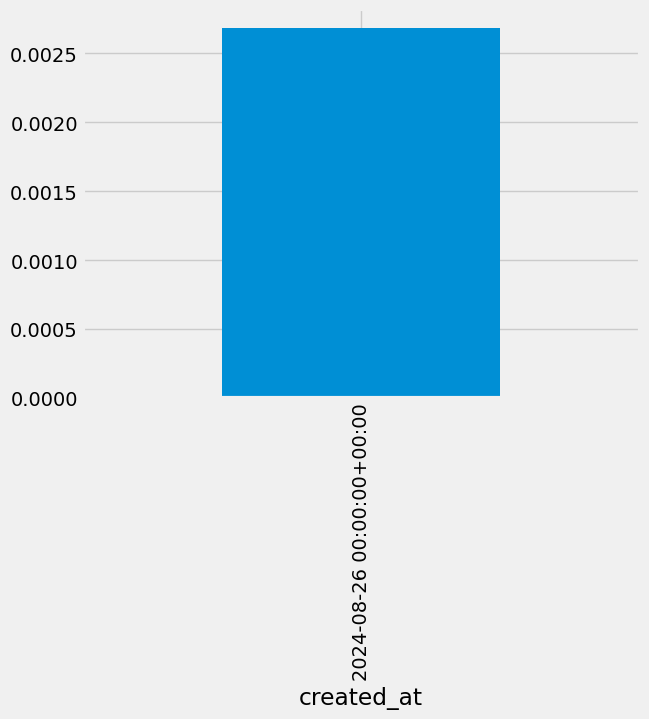

In [128]:
completions_df['cost'].resample('W-Mon').sum().sort_index().plot(kind='bar')

## **References**

1. Andrade-Udarbe, J. and Ballena, C. (2021). Exploring frontiers in electronic evidence: the philippine experience. Philippine Social Science Journal, 4(4), 104-112. https://doi.org/10.52006/main.v4i4.417
2. Arifany, P. (2021). Analisis implementasi pelaksanaan e-court di pengadilan agama. Jurnal Riset Hukum Keluarga Islam, 1(1), 37-42. https://doi.org/10.29313/jrhki.v1i1.199
3. Donoghue, J. (2017). The rise of digital justice: courtroom technology, public participation and access to justice. Modern Law Review, 80(6), 995-1025. https://doi.org/10.1111/1468-2230.12300
4. Eltis, K. (2011). The judicial system in the digital age: revisiting the relationship between privacy and accessibility in the cyber context. McGill Law Journal, 56(2), 289-316. https://doi.org/10.7202/1002368ar
5. Grepon, B. (2021). Designing and implementing e-justice systems: an information systems approach to regional trial court case docket management in northern mindanao, philippines.. https://doi.org/10.5281/zenodo.4459814
6. Guinigundo, D. (2021). A path to restorative justice: applicability of mental health courts in the philippines. Asian Journal of Legal Education, 8(2), 205-219. https://doi.org/10.1177/23220058211028411
7. Kondori, N. (2023). Identifying and ranking critical success factors for digital court. Journal of Organizational Change Management, 36(6), 1077-1094. https://doi.org/10.1108/jocm-03-2023-0087
8. Lee, S. and Narag, R. (2018). Fanning the flames: understanding gang involvement among philippine prisoners. International Journal of Offender Therapy and Comparative Criminology, 63(3), 424-447. https://doi.org/10.1177/0306624x18798225
9. Masriyani, M. (2024). Electronic court (e-court) at the sarolangun religious court. International Journal of Multidisciplinary Sciences and Arts, 2(2), 271-276. https://doi.org/10.47709/ijmdsa.v2i2.3603
10. Muhammad, M. (2023). Implementation of online registration e-court at indonesia religious courts. Arena Hukum, 16(02), 232-256. https://doi.org/10.21776/ub.arenahukum.2023.01602.2
11. Narag, R. (2017). Understanding factors related to prolonged trial of detained defendants in the philippines. International Journal of Offender Therapy and Comparative Criminology, 62(8), 2461-2487. https://doi.org/10.1177/0306624x17736041
12. Ngoepe, M. and Makhubela, S. (2015). “justice delayed is justice denied”. Records Management Journal, 25(3), 288-305. https://doi.org/10.1108/rmj-06-2015-0023
13. Santosa, D. (2023). How artificial intelligence can be useful for criminal courts in indonesia.. https://doi.org/10.4108/eai.28-10-2023.2341682
14. Setiawan, H. (2024). Digitalization of legal transformation on  judicial review in the constitutional court. Journal of Human Rights Culture and Legal System, 4(2), 263-298. https://doi.org/10.53955/jhcls.v4i2.263


## **Add Document**

In [96]:
url = 'https://elibrary.judiciary.gov.ph/thebookshelf/showdocs/29/26021'
doc2add = extract_text_data(url)
title = get_text_inside_brackets(doc2add)
summary_doc2add = summarize_text(doc2add)
summary_doc2add = '[' + title.strip() + '] ' + summary_doc2add
summary_doc2add[:50]

'[Commonwealth Act No. 1, December 21, 1935] There '

In [122]:
upload_texts_to_pinecone(
    texts=[summary_doc2add],
    batch_size=1,
    show_progress_bar=True,
    urls=[url]
)

100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


1

In [123]:
# Check stats to see if upsert was successful
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 318}},
 'total_vector_count': 318}